#CIFAR10 Dataset

In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo
!pip install /notebooks/pyade-master

#Import libraries
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms

import torchvision
#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG



Processing ./pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29472 sha256=8c60b49f1d426fa5f326c31ff77dd5fa93ded2d7062c249498582640d13eb755
  Stored in directory: /root/.cache/pip/wheels/98/25/f0/ab5adf3c6041d02e08073e288b6daf66206788126fdc60b442
Successfully built pyade-python
  Attempting uninstall: pyade-python
    Found existing installation: pyade-python 1.0
    Uninstalling pyade-python-1.0:
      Successfully uninstalled pyade-python-1.0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

utilsTFG.set_seed()

cuda


### Datos y modelos

In [3]:
#Load the CIFAR dataset
dataset='CIFAR'
plot_dataset='CIFAR-10'


#Import the CIFAR Dataset

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Resize([32,32]),
    transforms.Grayscale(num_output_channels=1)
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



# Reduce training and test datasets
reduced_train_dataset, valid_dataset = utilsTFG.reduce_dataset(train_dataset, 10000, 0.7, balance=True)
reduced_test_dataset = utilsTFG.reduce_dataset(test_dataset, 5000)



Files already downloaded and verified
Files already downloaded and verified


In [4]:

print("Training set class distribution:")
utilsTFG.verify_class_balance(reduced_train_dataset)

print("\nValidation set class distribution:")
utilsTFG.verify_class_balance(valid_dataset)

print("\nTest set class distribution:")
utilsTFG.verify_class_balance(reduced_test_dataset)

Training set class distribution:
Class 0: 700 samples
Class 1: 700 samples
Class 2: 700 samples
Class 3: 700 samples
Class 4: 700 samples
Class 5: 700 samples
Class 6: 700 samples
Class 7: 700 samples
Class 8: 700 samples
Class 9: 700 samples

Validation set class distribution:
Class 0: 300 samples
Class 1: 300 samples
Class 2: 300 samples
Class 3: 300 samples
Class 4: 300 samples
Class 5: 300 samples
Class 6: 300 samples
Class 7: 300 samples
Class 8: 300 samples
Class 9: 300 samples

Test set class distribution:
Class 0: 500 samples
Class 1: 500 samples
Class 2: 500 samples
Class 3: 500 samples
Class 4: 500 samples
Class 5: 500 samples
Class 6: 500 samples
Class 7: 500 samples
Class 8: 500 samples
Class 9: 500 samples


In [5]:
from torch.utils.data import DataLoader, random_split

# Define batch size
batch_size = 256

# Create DataLoader objects
train_loader = DataLoader(reduced_train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(reduced_test_dataset, batch_size=batch_size, shuffle=False)

# Check the size of each DataLoader
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(validation_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


Training set size: 7000
Validation set size: 3000
Test set size: 5000


In [6]:
dls = DataLoaders.from_dsets(reduced_train_dataset, valid_dataset, bs=batch_size)
test_dl = dls.test_dl(reduced_test_dataset)

dls.to(device)
test_dl.to(device)

models =['LeNet5', 'ResNet15', 'ResNet57']
mod = [utilsTFG.LeNet5(), utilsTFG.ResNet15(num_classes=10), utilsTFG.ResNet57(num_classes=10)]
optims = ['NAG', 'RMSProp', 'ADAM', 'ADAMW']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['accuracy']

init_weights = {}
for model, m in zip(models, mod):
  learn = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[model] = utilsTFG.get_params_from_model(learn.model)
  print(learn.summary())

LeNet5 (Input shape: 256 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 6 x 28 x 28   
Conv2d                                    156        True      
BatchNorm2d                               12         True      
____________________________________________________________________________
                     256 x 16 x 5 x 5    
MaxPool2d                                                      
____________________________________________________________________________
                     256 x 16 x 10 x 10  
Conv2d                                    2416       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     256 x 120           
Linear                                    48120      True      
BatchNorm1d                               240        True      
_________________________________________________

ResNet15 (Input shape: 256 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     256 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     256 x 64 x 13 x 13  
Conv2d                                    1024 

ResNet57 (Input shape: 256 x 1 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 26 x 26  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 64 x 13 x 13  
MaxPool2d                                                      
____________________________________________________________________________
                     256 x 16 x 13 x 13  
Conv2d                                    1024       True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     256 x 64 x 13 x 13  
Conv2d                                    1024 

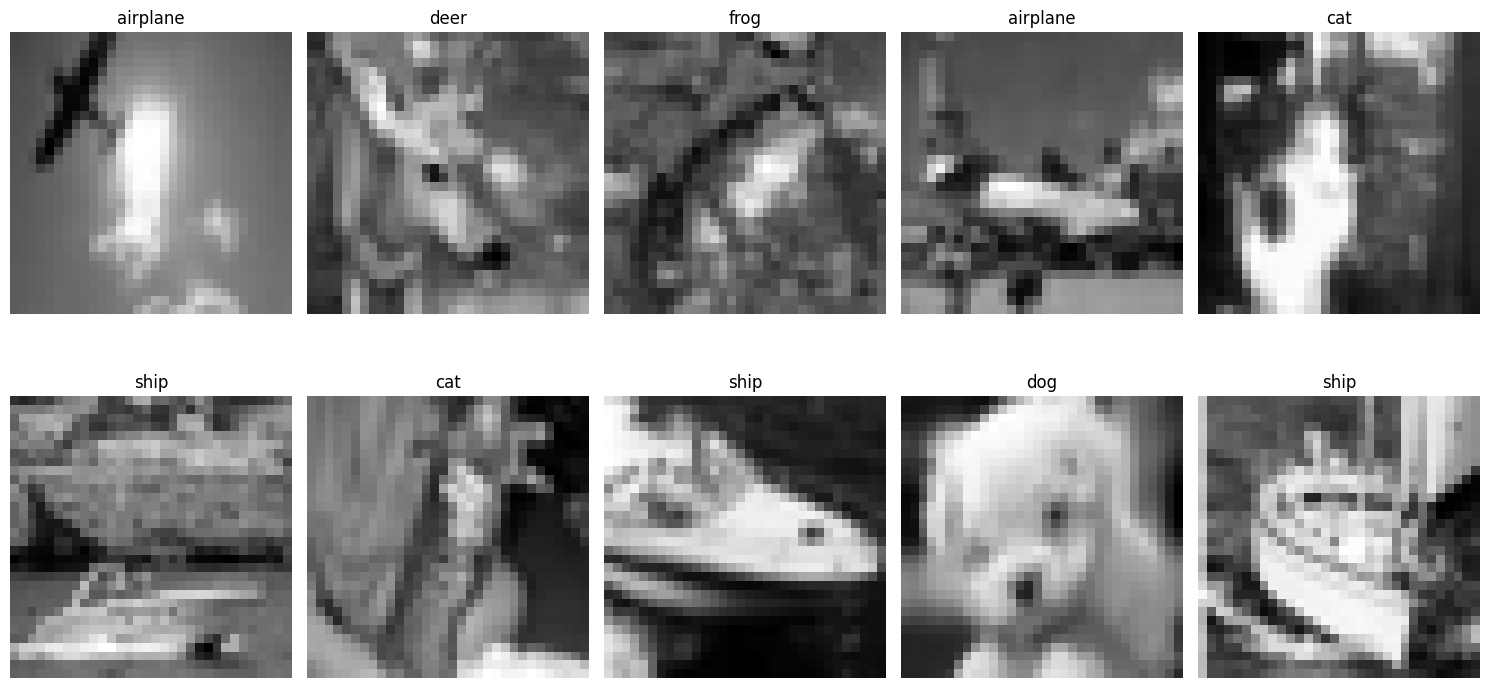

In [7]:
# Get a batch of images and labels
batch = dls.one_batch()

# Number of images to display
num_images = 10

# Create a figure with a grid of subplots (2 rows and 4 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

#Cifar10 classes name
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot each image in the grid
for i in range(num_images):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    img = batch[0][i].cpu().squeeze().numpy()
    label = class_names[batch[1][i].item()]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

## Gradient Descent

In [8]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
ADAMW = partial(OptimWrapper, opt=torch.optim.AdamW)
optims2 = [NAG, RMSProp, ADAM, ADAMW]
utilsTFG.set_seed()

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for model, m in zip(models,mod):
        learners[opt][model] = Learner(dls=dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), metrics=accuracy, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][model].to(device)
        learners[opt][model].model.to(device)
        utilsTFG.set_params_to_model(init_weights[model], learners[opt][model].model)


In [9]:
#To check if the models have the same initial parameters
for model in models:
  if utilsTFG.compare_models(learners['NAG'][model], learners['RMSProp'][model]) and utilsTFG.compare_models(learners['NAG'][model], learners['ADAM'][model]) and utilsTFG.compare_models(learners['ADAM'][model], learners['RMSProp'][model]):
    print(f"Mismos parámetros con el modelo {model}.")
  else:
    print("Distintos parámetros.")

Mismos parámetros con el modelo LeNet5.
Mismos parámetros con el modelo ResNet15.
Mismos parámetros con el modelo ResNet57.


### Nesterov

Better model found at epoch 0 with valid_loss value: 2.3426671028137207.
Better model found at epoch 1 with valid_loss value: 2.28169584274292.
Better model found at epoch 2 with valid_loss value: 1.9291412830352783.
Better model found at epoch 3 with valid_loss value: 1.8482328653335571.
Better model found at epoch 4 with valid_loss value: 1.773409128189087.
Better model found at epoch 5 with valid_loss value: 1.745700716972351.
Better model found at epoch 7 with valid_loss value: 1.7263883352279663.
Better model found at epoch 8 with valid_loss value: 1.6451419591903687.
Better model found at epoch 15 with valid_loss value: 1.587783694267273.
Better model found at epoch 16 with valid_loss value: 1.580020785331726.
Better model found at epoch 19 with valid_loss value: 1.5753105878829956.


Better model found at epoch 0 with valid_loss value: 2.4328174591064453.
Better model found at epoch 1 with valid_loss value: 2.4280219078063965.
Better model found at epoch 5 with valid_loss value: 2.186528205871582.
Better model found at epoch 6 with valid_loss value: 2.0908467769622803.
Better model found at epoch 7 with valid_loss value: 2.0746328830718994.
Better model found at epoch 8 with valid_loss value: 2.0414302349090576.
Better model found at epoch 9 with valid_loss value: 2.000704050064087.
Better model found at epoch 10 with valid_loss value: 1.9852313995361328.
Better model found at epoch 12 with valid_loss value: 1.9085335731506348.
Better model found at epoch 15 with valid_loss value: 1.8777928352355957.
Better model found at epoch 17 with valid_loss value: 1.8698694705963135.


Better model found at epoch 0 with valid_loss value: 2.478879451751709.
Better model found at epoch 4 with valid_loss value: 2.322324752807617.
Better model found at epoch 5 with valid_loss value: 2.2467823028564453.
Better model found at epoch 6 with valid_loss value: 2.2048323154449463.
Better model found at epoch 9 with valid_loss value: 2.151745080947876.
Better model found at epoch 11 with valid_loss value: 2.075302839279175.
Better model found at epoch 16 with valid_loss value: 2.0752878189086914.


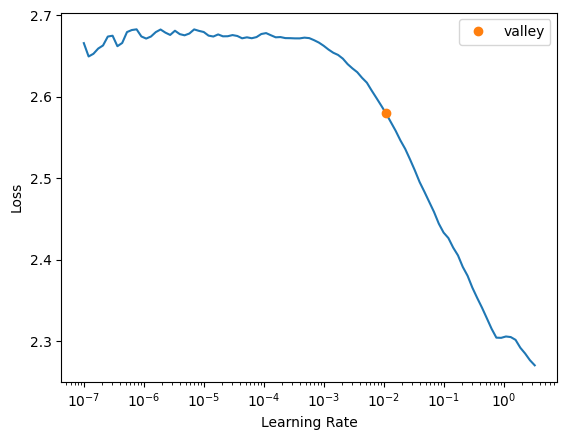

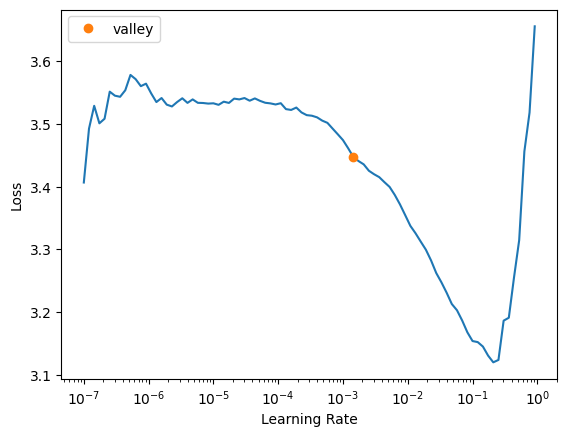

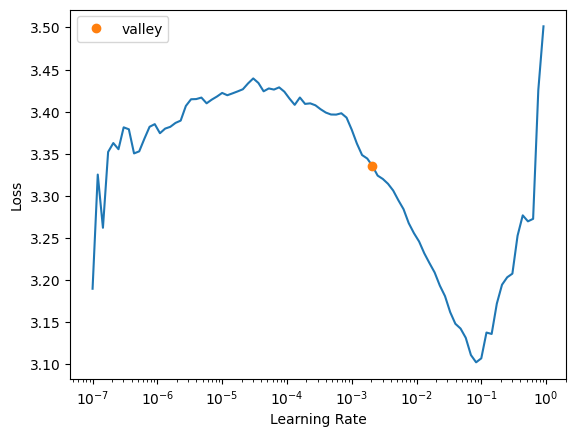

In [9]:
#Run the training and measure the time for each layer
for model, learner in learners['NAG'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][model] = end-start



<Figure size 1200x600 with 0 Axes>

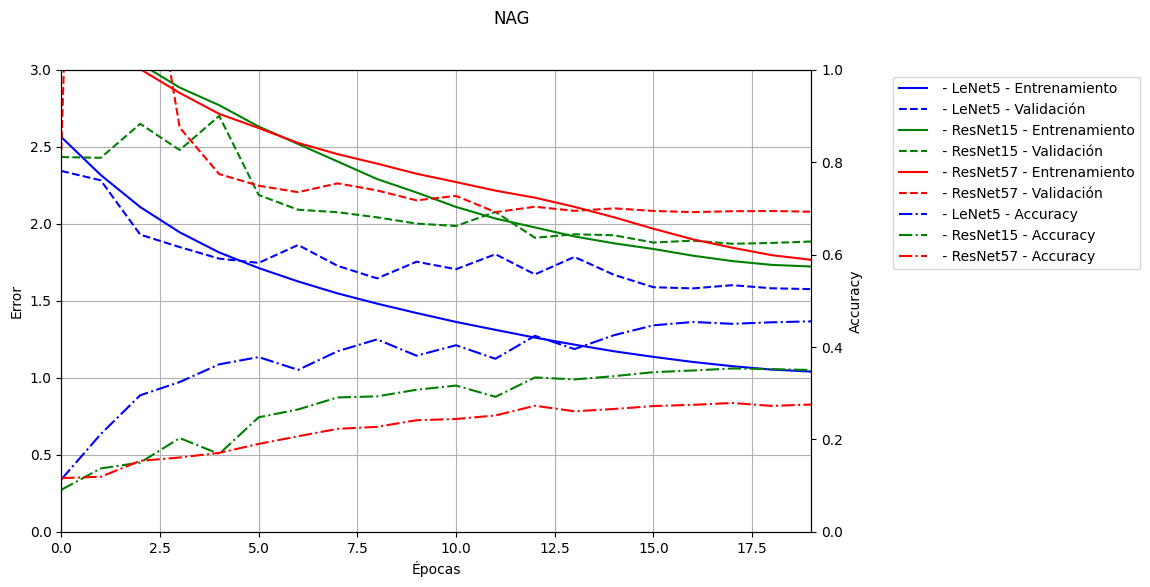

In [10]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), lim= 3, title='NAG', names=models, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 2.158453941345215.
Better model found at epoch 1 with valid_loss value: 2.1067075729370117.
Better model found at epoch 2 with valid_loss value: 1.9670119285583496.
Better model found at epoch 3 with valid_loss value: 1.9576807022094727.
Better model found at epoch 4 with valid_loss value: 1.9443074464797974.


Better model found at epoch 0 with valid_loss value: 3.1674680709838867.
Better model found at epoch 1 with valid_loss value: 2.9947428703308105.
Better model found at epoch 2 with valid_loss value: 1.9403616189956665.
Better model found at epoch 5 with valid_loss value: 1.8652288913726807.


Better model found at epoch 0 with valid_loss value: 2.6826915740966797.
Better model found at epoch 1 with valid_loss value: 2.472898483276367.
Better model found at epoch 2 with valid_loss value: 2.2057292461395264.
Better model found at epoch 3 with valid_loss value: 1.985405445098877.


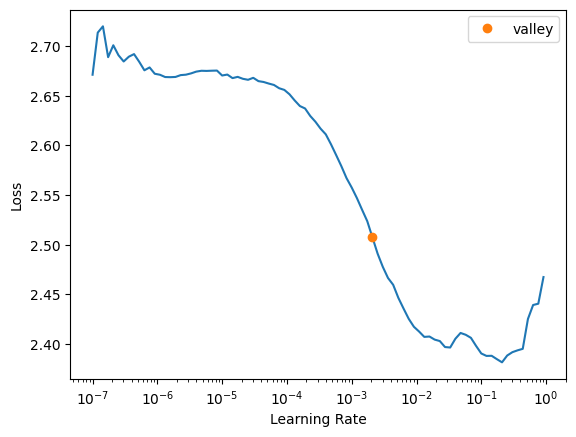

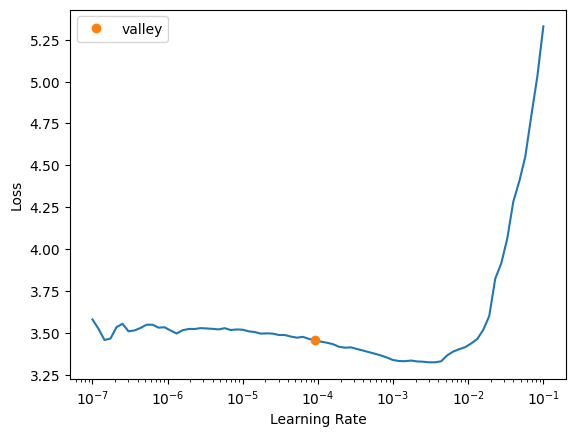

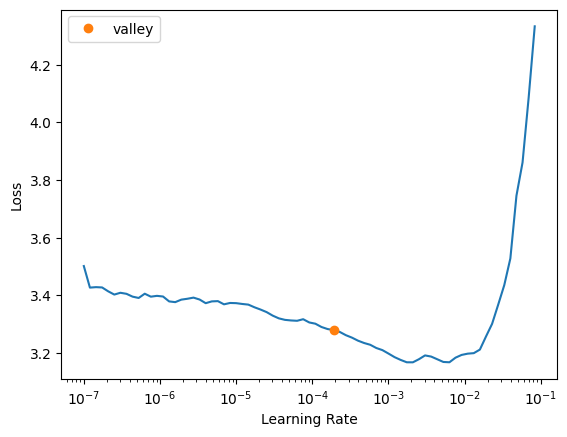

In [11]:
#Run the training and measure the time for each layer
for model, learner in learners['RMSProp'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][model] = end-start


<Figure size 1200x600 with 0 Axes>

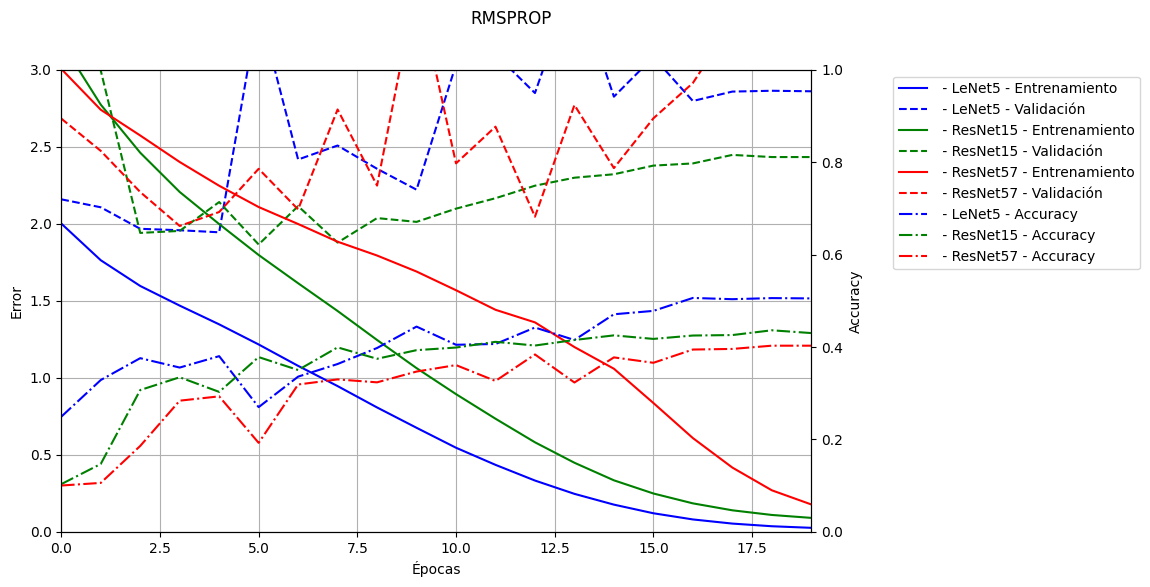

In [12]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), lim= 3, title='RMSPROP', names=models, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 2.3243956565856934.
Better model found at epoch 1 with valid_loss value: 2.0185582637786865.
Better model found at epoch 2 with valid_loss value: 1.8397729396820068.
Better model found at epoch 3 with valid_loss value: 1.7450613975524902.
Better model found at epoch 4 with valid_loss value: 1.7291086912155151.
Better model found at epoch 6 with valid_loss value: 1.6541258096694946.


Better model found at epoch 0 with valid_loss value: 2.5088419914245605.
Better model found at epoch 2 with valid_loss value: 2.2186715602874756.
Better model found at epoch 3 with valid_loss value: 2.076738119125366.
Better model found at epoch 5 with valid_loss value: 1.964661955833435.
Better model found at epoch 9 with valid_loss value: 1.9563616514205933.


Better model found at epoch 0 with valid_loss value: 2.6348907947540283.
Better model found at epoch 1 with valid_loss value: 2.5879769325256348.
Better model found at epoch 2 with valid_loss value: 2.320296287536621.
Better model found at epoch 3 with valid_loss value: 2.2152726650238037.
Better model found at epoch 5 with valid_loss value: 2.0885629653930664.
Better model found at epoch 6 with valid_loss value: 2.0613863468170166.
Better model found at epoch 7 with valid_loss value: 1.979628562927246.
Better model found at epoch 10 with valid_loss value: 1.8734668493270874.


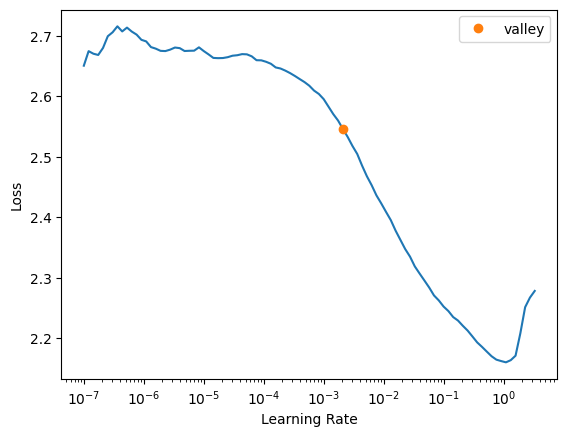

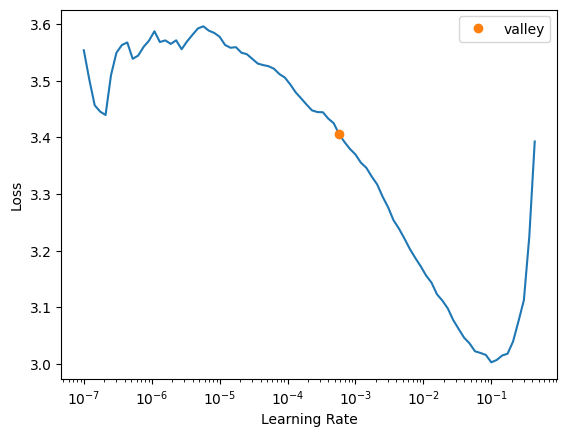

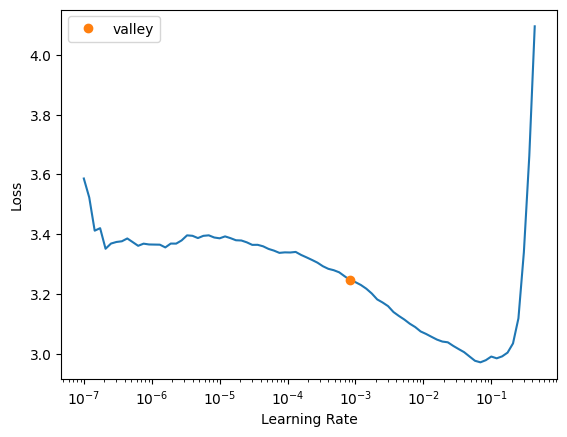

In [13]:
#Run the training and measure the time for each layer
for model, learner in learners['ADAM'].items():
  utilsTFG.set_seed()
  try:
    lr=learner.lr_find()
  except:
    lr=0.01
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][model] = end-start


<Figure size 1200x600 with 0 Axes>

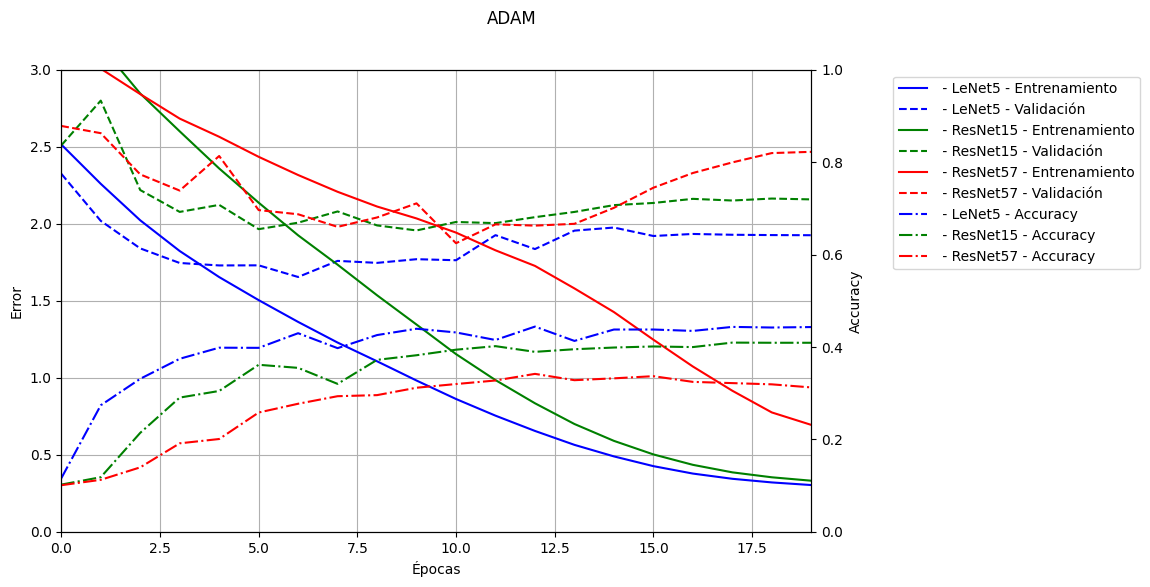

In [14]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), lim= 3, title='ADAM', names=models, metric=metric)

### AdamW

Better model found at epoch 0 with valid_loss value: 2.2970101833343506.
Better model found at epoch 1 with valid_loss value: 1.9576414823532104.
Better model found at epoch 2 with valid_loss value: 1.7930724620819092.
Better model found at epoch 3 with valid_loss value: 1.6951868534088135.


Better model found at epoch 0 with valid_loss value: 2.6668033599853516.
Better model found at epoch 2 with valid_loss value: 2.1131768226623535.
Better model found at epoch 4 with valid_loss value: 1.958633303642273.
Better model found at epoch 7 with valid_loss value: 1.9208858013153076.


Better model found at epoch 0 with valid_loss value: 2.689547061920166.
Better model found at epoch 1 with valid_loss value: 2.5435073375701904.
Better model found at epoch 2 with valid_loss value: 2.2463555335998535.
Better model found at epoch 3 with valid_loss value: 2.195465087890625.
Better model found at epoch 5 with valid_loss value: 2.0060231685638428.
Better model found at epoch 7 with valid_loss value: 1.9304897785186768.
Better model found at epoch 8 with valid_loss value: 1.9022701978683472.
Better model found at epoch 12 with valid_loss value: 1.9019571542739868.


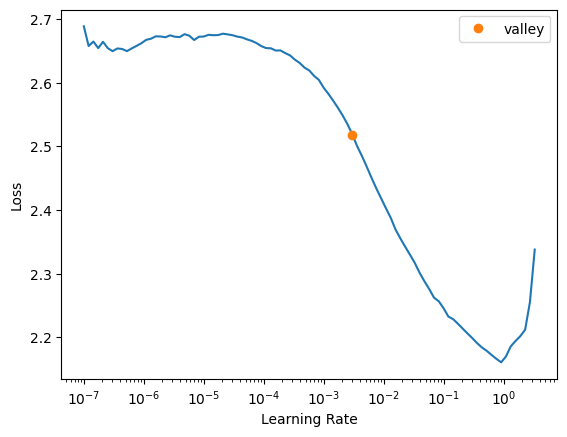

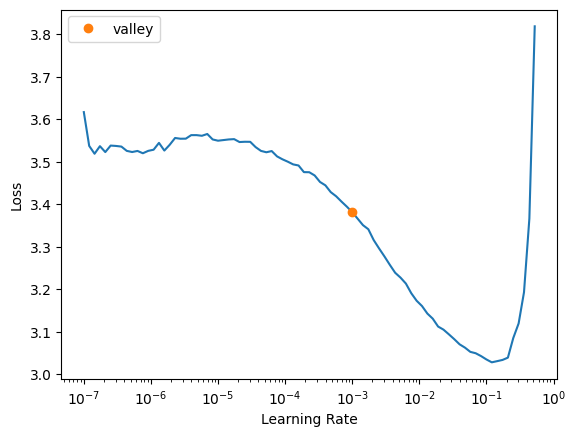

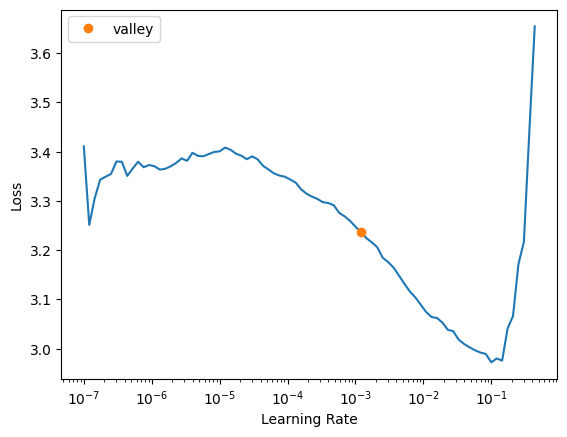

In [16]:
#Run the training and measure the time for each layer
for model, learner in learners['ADAMW'].items():
  utilsTFG.set_seed()
  try:
    lr=learner.lr_find()
  except:
    lr=0.01
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAMW'][model] = end-start

<Figure size 1200x600 with 0 Axes>

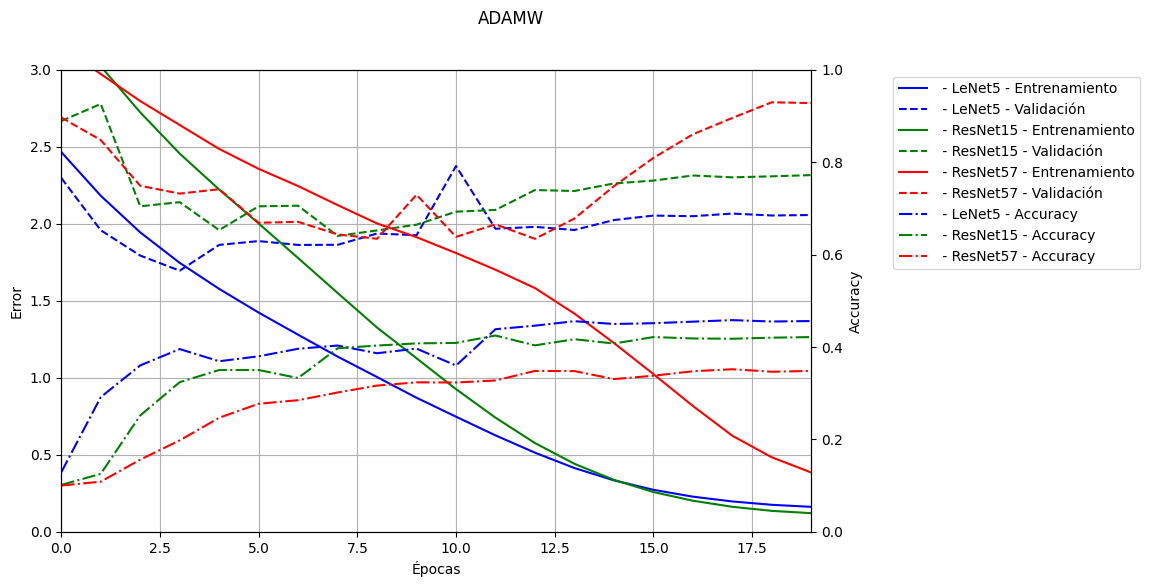

In [17]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAMW'].values(), lim= 3, title='ADAMW', names=models, metric=metric)

### Save or Load models

In [18]:
#Save learner with their losses and metrics
models=['LeNet5', 'ResNet15', 'ResNet57']
for optim in optims:
  for model in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][model], 'recorder_values': learners[optim][model].recorder.values}, f)

file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_gd, f)

In [10]:
models =['LeNet5', 'ResNet15', 'ResNet57']
mod = [utilsTFG.LeNet5(), utilsTFG.ResNet15(num_classes=10), utilsTFG.ResNet57(num_classes=10)]
optims = ['NAG', 'RMSProp', 'ADAM', 'ADAMW']
metric = ['accuracy']
dataset='CIFAR'
plot_dataset='CIFAR-10'


#Load learner with their losses and metrics
learners = {}
for optim in optims:
  learners[optim] = {}
  for model in models:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{model}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][model], learners[optim][model].recorder.values = data['learner'], data['recorder_values']

    
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'rb') as f:
    time_gd = pickle.load(f)

### Comparative per models

<Figure size 1200x600 with 0 Axes>

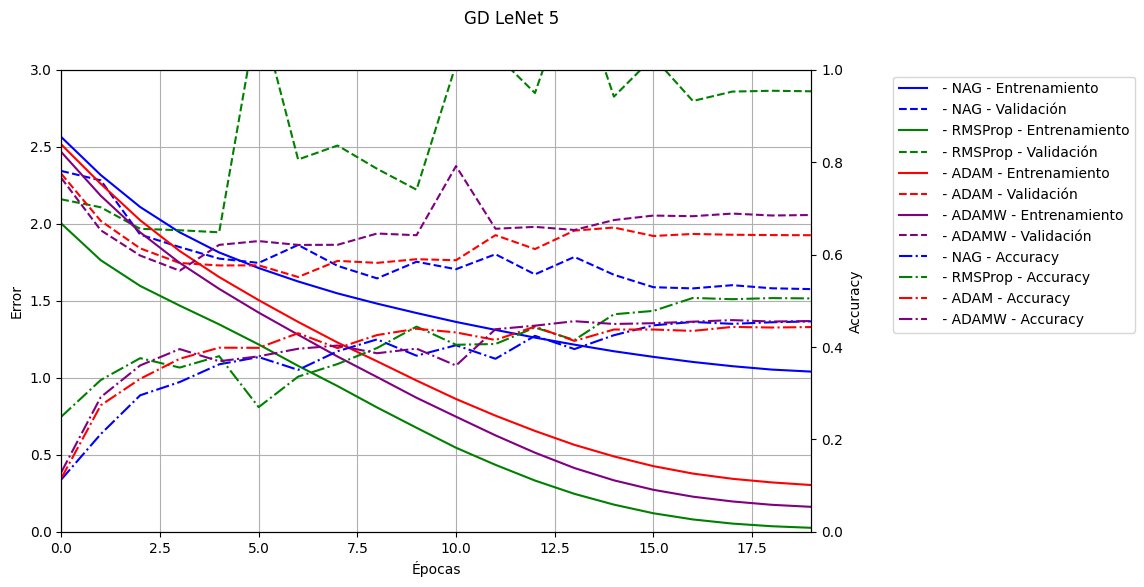

<Figure size 1200x600 with 0 Axes>

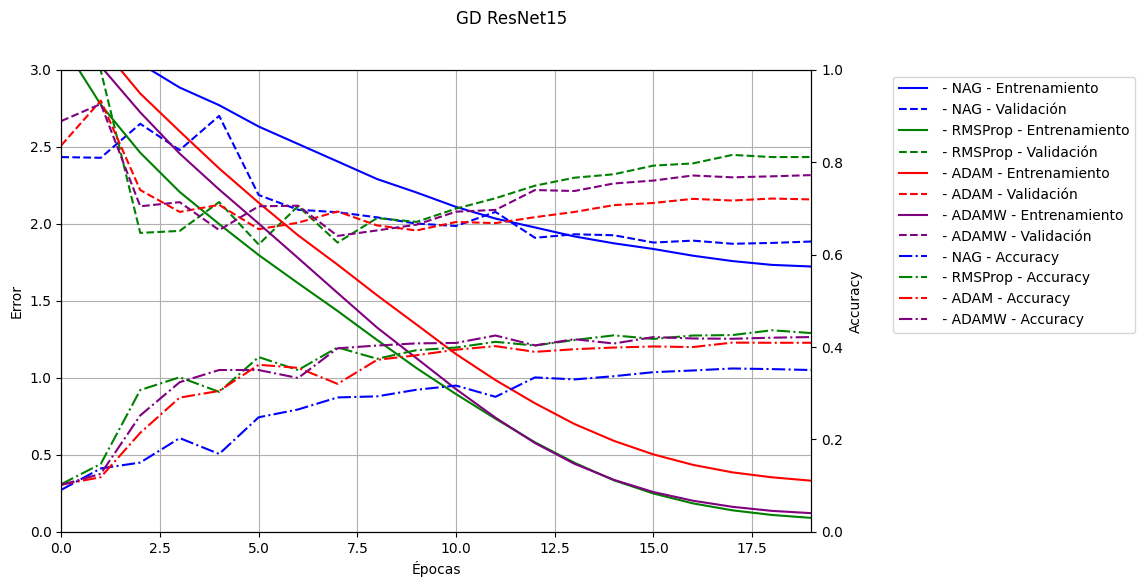

<Figure size 1200x600 with 0 Axes>

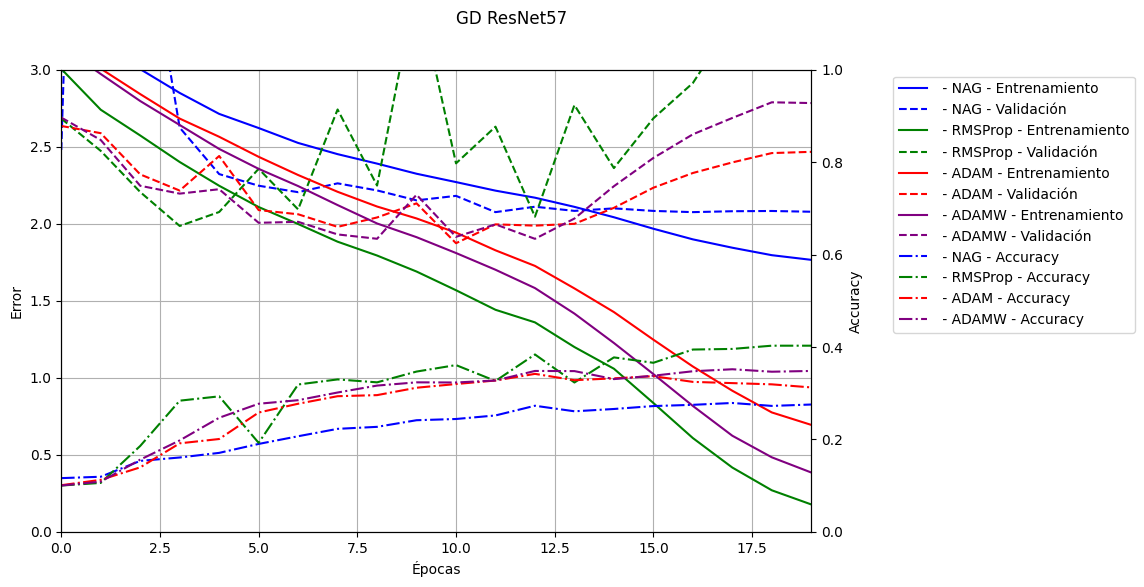

In [4]:
#Compare the three optimizers for each layer

learners_lenet =[learners['NAG']['LeNet5'], learners['RMSProp']['LeNet5'], learners['ADAM']['LeNet5'], learners['ADAMW']['LeNet5']]
learners_resnet = [learners['NAG']['ResNet15'], learners['RMSProp']['ResNet15'], learners['ADAM']['ResNet15'], learners['ADAMW']['ResNet15']]
learners_resnet57 = [learners['NAG']['ResNet57'], learners['RMSProp']['ResNet57'], learners['ADAM']['ResNet57'], learners['ADAMW']['ResNet57']]

names=['NAG', 'RMSProp', 'ADAM', 'ADAMW']
utilsTFG.plot_learners_training(learners_lenet, lim= 3, title='GD LeNet 5', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet, lim= 3, title='GD ResNet15', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_resnet57, lim= 3, title='GD ResNet57', names=names, metric=metric)

### Generalization

In [11]:
models =['LeNet5', 'ResNet15', 'ResNet57'] #Sometimes it overrides the array
#Run the model in the test set
for optim in optims:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][model].model.eval()
    learners[optim][model].eval()
    preds, targs = learners[optim][model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][model].model, test_dl, mode = 'test')
    #loss = CrossEntropyLossFlat()(preds, targs)


    print(f"Optimizer: {optim}, Model: {model}, Loss: {loss}, Accuracy: {accuracy}")

Optimizer: NAG, Model: LeNet5, Loss: 1.6024788618087769, Accuracy: 0.4366


Optimizer: NAG, Model: ResNet15, Loss: 1.8553450107574463, Accuracy: 0.3504


Optimizer: NAG, Model: ResNet57, Loss: 2.0600156784057617, Accuracy: 0.2826


Optimizer: RMSProp, Model: LeNet5, Loss: 2.038503408432007, Accuracy: 0.3598


Optimizer: RMSProp, Model: ResNet15, Loss: 1.8479381799697876, Accuracy: 0.3822


Optimizer: RMSProp, Model: ResNet57, Loss: 1.9805630445480347, Accuracy: 0.28279999999999994


Optimizer: ADAM, Model: LeNet5, Loss: 1.6594666242599487, Accuracy: 0.40920000000000006


Optimizer: ADAM, Model: ResNet15, Loss: 1.9592403173446655, Accuracy: 0.36579999999999996


Optimizer: ADAM, Model: ResNet57, Loss: 1.8921769857406616, Accuracy: 0.33480000000000004


Optimizer: ADAMW, Model: LeNet5, Loss: 1.683121919631958, Accuracy: 0.399


Optimizer: ADAMW, Model: ResNet15, Loss: 1.8949495553970337, Accuracy: 0.3748


Optimizer: ADAMW, Model: ResNet57, Loss: 1.9187854528427124, Accuracy: 0.3532


## Metaheuristics

In [9]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
ADAMW = partial(OptimWrapper, opt=torch.optim.AdamW)
utilsTFG.set_seed()
#Initialise the population to have the same values for all the MH
for model,m in zip(models,mod):
  population[model] = []
  fitness[model] = []
  optim = NAG if model=='LeNet5' else RMSProp
  mh_learners[model] = Learner(dls, model=copy.deepcopy(m), loss_func=CrossEntropyLossFlat(), opt_func=optim,  cbs=[SaveModelCallback()])
  mh_learners[model].to(device)
  mh_learners[model].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[model].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    #population[model].append(utilsTFG.get_params_from_model(model_copy))

    #fitness[model].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


In [10]:

file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(population, f)

file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(fitness, f)

In [11]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'rb') as f:
    population = pickle.load(f)

file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'rb') as f:
    fitness = pickle.load(f)

In [ ]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

In [10]:
models=['LeNet5', 'ResNet15', 'ResNet57']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
fitness_valid = {}
results = {}
time_mh = {}
for alg in algs:
    results[alg] = {}
    time_mh[alg] = {}
    for model in models:        
        file_path = f'/notebooks/saved_models/{alg}_dict_{model}_{dataset}.pkl'
        with open(file_path, 'rb') as f:
            results[alg][model] = pickle.load(f)
        file_path = f'/notebooks/saved_models/{alg}_time_{model}_{dataset}.pkl'
        with open(file_path, 'rb') as f:
            time_mh[alg][model] = pickle.load(f)

In [11]:
time_full_mh = {}
for alg in ['SHADE', 'SHADE-ILS']:
    time_full_mh[alg]= time_mh[alg]

### SHADE

In [11]:
#Runing SHADE algorithm

results['SHADE'] = {}
for model in {'LeNet5', 'ResNet15'}:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][model] = utilsTFG.SHADE_ej(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), pop_size,max_evals, len(population[model][0]), dls,  model=mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'][model], f)
  file_path = f'/notebooks/saved_models/SHADE_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'][model], f)


In [ ]:
results['SHADE'] = {}
for model in ['ResNet57']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][model] = utilsTFG.SHADE_ej(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), pop_size,max_evals, len(population[model][0]), dls,  model=mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'][model], f)
  file_path = f'/notebooks/saved_models/SHADE_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'][model], f)

In [12]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for model in models:
  fitness_valid['SHADE'][model] = []
  start = time.perf_counter()
  for ind in results['SHADE'][model][5]:
    fitness_valid['SHADE'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))
  end = time.perf_counter()
  time_full_mh['SHADE'][model]+= end-start


In [13]:
#compare train and valid and select the best generalizing model.
for model in models:
  print(f"Training error of SHADE for {model} model: {results['SHADE'][model][6]}")
  print(f"Validation error of SHADE for {model} model: {fitness_valid['SHADE'][model]}")
  dif = np.array(fitness_valid['SHADE'][model]) - np.array(results['SHADE'][model][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][model])
  best['SHADE'][model] = results['SHADE'][model][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for LeNet5 model: [2.567852735519409, 2.547703742980957, 2.4759209156036377, 2.4208271503448486, 2.378920316696167, 2.378920316696167, 2.3755528926849365, 2.3755528926849365, 2.3539085388183594, 2.328537702560425, 2.3182950019836426, 2.3182950019836426, 2.2965259552001953, 2.285963773727417, 2.281792640686035, 2.2665560245513916, 2.262084484100342, 2.2488231658935547, 2.239049196243286, 2.226195812225342, 2.2229325771331787, 2.22017765045166, 2.2169487476348877, 2.2112553119659424, 2.2080674171447754, 2.2007811069488525, 2.1980130672454834, 2.194398880004883, 2.1926066875457764, 2.1922178268432617, 2.1885547637939453, 2.188199281692505, 2.1860718727111816, 2.1856181621551514, 2.1856181621551514, 2.185213088989258, 2.1843273639678955, 2.1842808723449707, 2.182384729385376, 2.182384729385376, 2.1816494464874268, 2.1816494464874268, 2.1816494464874268, 2.179089069366455, 2.177443742752075, 2.1758649349212646, 2.175567626953125, 2.1745433807373047, 2.174278736114502

In [13]:
#Modify the shade lenght to adjust the others algorithms. I have selected the best before so we cant lose it.
for model in models:
    # Convert the tuple to a list
    shade_list = list(results['SHADE'][model])
    
    # Modify the list
    shade_list[6] = [np.mean(shade_list[6][i:i+5]) for i in range(0, len(shade_list[6]), 5)]
    
    # Convert the list back to a tuple and assign it back to results['SHADE'][layer]
    results['SHADE'][model] = tuple(shade_list)
    
    
    
    fitness_valid['SHADE'][model] = [np.mean(fitness_valid['SHADE'][model][i:i+5]) for i in range(0, len(fitness_valid['SHADE'][model]), 5)]

### SHADE-ILS

In [13]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for model in ['LeNet5', 'ResNet15'] :
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS'][model] = utilsTFG.SHADE_ILS(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-ILS_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS'][model], f)


deque([1, 1, 0.434579779403743], maxlen=3)
233
deque([1, 0.434579779403743, 0.10661097332553994], maxlen=3)
445
deque([0.434579779403743, 0.10661097332553994, 0.09929750533012396], maxlen=3)
658
deque([0.10661097332553994, 0.09929750533012396, 0.08217453700609605], maxlen=3)
871
deque([0.09929750533012396, 0.08217453700609605, 0.009548257336591051], maxlen=3)
1084
deque([0.08217453700609605, 0.009548257336591051, 0.05981660870331387], maxlen=3)
1298
deque([0.009548257336591051, 0.05981660870331387, 0.05748452474482886], maxlen=3)
1511
deque([0.05981660870331387, 0.05748452474482886, 0.07681336666868695], maxlen=3)
1724
deque([0.05748452474482886, 0.07681336666868695, 0.08127634463453727], maxlen=3)
1937
deque([0.07681336666868695, 0.08127634463453727, 0.07764290416913297], maxlen=3)
2150
deque([0.08127634463453727, 0.07764290416913297, -0.00037636413784885024], maxlen=3)
2359
deque([0.07764290416913297, -0.00037636413784885024, 0.000562998541399208], maxlen=3)
2571
deque([-0.0003763641

In [17]:
for model in ['ResNet57'] :
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS'][model] = utilsTFG.SHADE_ILS(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-ILS_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS'][model], f)

eo
deque([1, 0.03938740290556164, 0.15962756286460789], maxlen=3)
deque([0.03938740290556164, 0.15962756286460789, 0.016949839991087637], maxlen=3)
242
eo
deque([0.15962756286460789, 0.016949839991087637, 0.007912602583564528], maxlen=3)
deque([0.016949839991087637, 0.007912602583564528, 0.008961820134466234], maxlen=3)
Reiniciado
465
eo
deque([1, 1, 0.8954269429586572], maxlen=3)
deque([1, 0.8954269429586572, -0.0028127046319012796], maxlen=3)
679
eo
deque([0.8954269429586572, -0.0028127046319012796, 0.06452476866750372], maxlen=3)
deque([-0.0028127046319012796, 0.06452476866750372, -0.004514968024014382], maxlen=3)
893
eo
deque([0.06452476866750372, -0.004514968024014382, 0.017728445763078776], maxlen=3)
deque([-0.004514968024014382, 0.017728445763078776, -0.01447423240781011], maxlen=3)
Reiniciado
1117
eo
deque([1, 1, 0.8978610568925649], maxlen=3)
deque([1, 0.8978610568925649, 0.0649385745588531], maxlen=3)
1331
eo
deque([0.8978610568925649, 0.0649385745588531, 0.005016011829233994

In [14]:
fitness_valid['SHADE-ILS'] = {}
for model in models:
  fitness_valid['SHADE-ILS'][model] = []
  start = time.perf_counter()
  for ind in results['SHADE-ILS'][model][3]:
    fitness_valid['SHADE-ILS'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))
  end = time.perf_counter()
  time_full_mh['SHADE-ILS'][model] += end-start

In [15]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS for {model} model: {results['SHADE-ILS'][model][2]}")
  print(f"Validation error of SHADE-ILS for {model} model: {fitness_valid['SHADE-ILS'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS'][model]) - np.array(results['SHADE-ILS'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][model])
  best['SHADE-ILS'][model] = results['SHADE-ILS'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for LeNet5 model: [2.567852735519409, 1.4519158601760864, 1.2971256971359253, 1.16832435131073, 1.0723178386688232, 1.0620790719985962, 0.9985491037368774, 0.9411479830741882, 0.8688552379608154, 0.7982378602027893, 0.7362603545188904, 0.7362603545188904, 0.7361227869987488, 0.7269812822341919, 0.7269812822341919, 0.7269812822341919, 0.7269812822341919, 0.7269812822341919, 0.7269812822341919, 0.7269812822341919, 0.7269812822341919]
Validation error of SHADE-ILS for LeNet5 model: [2.3009283542633057, 2.4037747383117676, 2.59185791015625, 2.5342907905578613, 2.584819793701172, 2.5628576278686523, 2.524881362915039, 2.5651330947875977, 2.513000249862671, 2.5223755836486816, 2.4982664585113525, 2.4982664585113525, 2.5082507133483887, 2.4934897422790527, 2.4934897422790527, 2.4934897422790527, 2.4934897422790527, 2.4934897422790527, 2.4934897422790527, 2.4934897422790527, 2.4934897422790527]
Difference: [-0.26692438  0.95185888  1.29473221  1.36596644  1.51250196

### SHADE-GD

In [ ]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for model in ['LeNet5', 'ResNet15']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-GD'][model] = utilsTFG.SHADE_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-GD'][model], f)


deque([1, 1, 0.07595645640278338], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.226971387863159.
deque([1, 0.07595645640278338, 0.13638687910314393], maxlen=3)
deque([0.07595645640278338, 0.13638687910314393, 0.09231450402604237], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.8178118467330933.
deque([0.13638687910314393, 0.09231450402604237, 0.035246126008246], maxlen=3)
deque([0.09231450402604237, 0.035246126008246, 0.05646588235888097], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.8485937118530273.
deque([0.035246126008246, 0.05646588235888097, 0.01237228347711831], maxlen=3)
deque([0.05646588235888097, 0.01237228347711831, 0.054205178140674555], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.714372992515564.
deque([0.01237228347711831, 0.054205178140674555, 0.008859904605124308], maxlen=3)
deque([0.054205178140674555, 0.008859904605124308, 0.010114061339302064], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7137166261672974.
deque([0.008859904605124308, 0.010114061339302064, 0.0003765243628394961], maxlen=3)
Reiniciado
deque([1, 1, 0.03346440854011628], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.1221442222595215.
deque([1, 0.03346440854011628, 0.12410252322709994], maxlen=3)
deque([0.03346440854011628, 0.12410252322709994, 0.07588585805207079], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.9610601663589478.
deque([0.12410252322709994, 0.07588585805207079, 0.041047050921996724], maxlen=3)
deque([0.07588585805207079, 0.041047050921996724, 0.051189940191862994], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.777428388595581.
deque([0.041047050921996724, 0.051189940191862994, 0.04187002726384287], maxlen=3)
deque([0.051189940191862994, 0.04187002726384287, 0.07797427981142589], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7641655206680298.
deque([0.04187002726384287, 0.07797427981142589, 0.009846261383942938], maxlen=3)
deque([0.07797427981142589, 0.009846261383942938, 0.02323845449204036], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.0556068420410156.
deque([0.009846261383942938, 0.02323845449204036, 0.002191133100585556], maxlen=3)
Reiniciado
deque([1, 1, 0.0041332733293888485], maxlen=3)
deque([1, 1, 0.20138621308171406], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.0169613361358643.
deque([1, 0.20138621308171406, 0.16633515778238192], maxlen=3)
deque([0.20138621308171406, 0.16633515778238192, 0.09071678211976258], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.9812887907028198.
deque([0.16633515778238192, 0.09071678211976258, 0.046866403612164584], maxlen=3)
deque([0.09071678211976258, 0.046866403612164584, 0.0805358451354117], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.8569055795669556.
deque([0.046866403612164584, 0.0805358451354117, -0.00022821946876868833], maxlen=3)
deque([0.0805358451354117, -0.00022821946876868833, 0.017739934942480853], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.843694806098938.
deque([-0.00022821946876868833, 0.017739934942480853, 0.0], maxlen=3)
Reiniciado
deque([1, 1, 0.46106960582728745], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.171299695968628.
deque([1, 0.46106960582728745, 0.14241581027774416], maxlen=3)
deque([0.46106960582728745, 0.14241581027774416, 0.029006401592091977], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.0377206802368164.
deque([0.14241581027774416, 0.029006401592091977, 0.03717714947700812], maxlen=3)
deque([0.029006401592091977, 0.03717714947700812, 0.04977203695268402], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 2.1997411251068115.
deque([1, 1, 0.543238475659975], maxlen=3)
deque([1, 0.543238475659975, 0.06594445478710811], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.1656558513641357.
deque([0.543238475659975, 0.06594445478710811, 0.027098515762168682], maxlen=3)
deque([0.06594445478710811, 0.027098515762168682, 0.09892665585523336], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.8850035667419434.
deque([0.027098515762168682, 0.09892665585523336, 0.02045169471955005], maxlen=3)
deque([0.09892665585523336, 0.02045169471955005, 0.03855946594578581], maxlen=3)


In [ ]:
for model in ['ResNet57']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-GD'][model] = utilsTFG.SHADE_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]), max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-GD'][model], f)


deque([1, 1, 0.18286334683734812], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.387993574142456.
deque([1, 0.18286334683734812, 0.08691141341978065], maxlen=3)
deque([0.18286334683734812, 0.08691141341978065, 0.0034149179980841895], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.2332823276519775.
deque([0.08691141341978065, 0.0034149179980841895, 0.0350721972236903], maxlen=3)
deque([0.0034149179980841895, 0.0350721972236903, 0.03843550841171904], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 2.282802104949951.
deque([1, 1, 0.5041643192973373], maxlen=3)
deque([1, 0.5041643192973373, 0.024137478574067728], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.2696869373321533.
deque([0.5041643192973373, 0.024137478574067728, 0.020517331796298832], maxlen=3)
deque([0.024137478574067728, 0.020517331796298832, 0.02530076175871685], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 2.248175859451294.
deque([1, 1, 0.5179766416656986], maxlen=3)
deque([1, 0.5179766416656986, 0.035643402365778176], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.209625482559204.
deque([0.5179766416656986, 0.035643402365778176, 0.012006159210314556], maxlen=3)
deque([0.035643402365778176, 0.012006159210314556, 0.01827798908919591], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 2.293802261352539.
deque([1, 1, 0.45168974913356663], maxlen=3)
deque([1, 0.45168974913356663, 0.019471989506805433], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.2500782012939453.
deque([0.45168974913356663, 0.019471989506805433, 0.022423281084262302], maxlen=3)
deque([0.019471989506805433, 0.022423281084262302, 0.029834329820349007], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 2.3898842334747314.
deque([1, 1, 0.4882583310364772], maxlen=3)
deque([1, 0.4882583310364772, 0.010295074567851021], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.569037675857544.
deque([0.4882583310364772, 0.010295074567851021, 0.03744872023842796], maxlen=3)
deque([0.010295074567851021, 0.03744872023842796, 0.015305275692986819], maxlen=3)
Reiniciado


In [16]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for model in models:
  fitness_valid['SHADE-GD'][model] = []
  for ind in results['SHADE-GD'][model][3]:
    fitness_valid['SHADE-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [17]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-GD for {model} model: {results['SHADE-GD'][model][2]}")
  print(f"Validation error of SHADE-GD for {model} model: {fitness_valid['SHADE-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-GD'][model]) - np.array(results['SHADE-GD'][model][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][model])
  best['SHADE-GD'][model] = results['SHADE-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for LeNet5 model: [2.567852735519409, 2.372807741165161, 2.0491878986358643, 1.8600181341171265, 1.7944597005844116, 1.6931339502334595, 1.672186017036438, 1.5815448760986328, 1.5675325393676758, 1.5516784191131592, 1.5510941743850708, 1.5510941743850708, 1.5510941743850708, 1.5510941743850708, 1.5510941743850708, 1.5510941743850708, 1.5510941743850708, 1.5335288047790527, 1.5184292793273926, 1.4831433296203613, 1.4798935651779175, 1.4798935651779175]
Validation error of SHADE-GD for LeNet5 model: [2.3009283542633057, 2.3017191886901855, 2.2822799682617188, 2.289580821990967, 2.283647060394287, 2.2845726013183594, 2.2823705673217773, 2.281298875808716, 2.281648635864258, 2.281837224960327, 2.2811148166656494, 2.2811148166656494, 2.2811148166656494, 2.2811148166656494, 2.2811148166656494, 2.2811148166656494, 2.2811148166656494, 2.2752761840820312, 2.2755911350250244, 2.2747743129730225, 2.277024745941162, 2.277024745941162]
Difference: [-0.26692438 -0.07108855

### SHADE-ILS-GD

deque([1, 1, 0.44550727436560816], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.6090129613876343.
deque([1, 0.44550727436560816, 0.09451617680831154], maxlen=3)
deque([0.44550727436560816, 0.09451617680831154, 0.06502466424724347], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.5525237321853638.
deque([0.09451617680831154, 0.06502466424724347, 0.02073350137144096], maxlen=3)
deque([0.06502466424724347, 0.02073350137144096, 0.00595061669798083], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.527630090713501.
deque([0.02073350137144096, 0.00595061669798083, 0.00039701688744042966], maxlen=3)
Reiniciado
deque([1, 1, 0.3621058384422665], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7087420225143433.
deque([1, 0.3621058384422665, 0.13683911082389508], maxlen=3)
deque([0.3621058384422665, 0.13683911082389508, 0.014953512653172935], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.6772042512893677.
deque([0.13683911082389508, 0.014953512653172935, 0.07189231335220589], maxlen=3)
deque([0.014953512653172935, 0.07189231335220589, -0.0019922643950814395], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.5868083238601685.
deque([0.07189231335220589, -0.0019922643950814395, 0.09530542898086462], maxlen=3)
deque([-0.0019922643950814395, 0.09530542898086462, 0.10670914467745495], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.5854442119598389.
deque([0.09530542898086462, 0.10670914467745495, 0.056390073546338626], maxlen=3)
deque([0.10670914467745495, 0.056390073546338626, 0.013245169544820407], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.5868676900863647.
deque([0.056390073546338626, 0.013245169544820407, 0.0002833153796481029], maxlen=3)
deque([0.013245169544820407, 0.0002833153796481029, 0.0011686941883492443], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 2.0165393352508545.
deque([1, 1, 0.36503457990233745], maxlen=3)
deque([1, 0.36503457990233745, 0.14928876845989397], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.8391954898834229.
deque([0.36503457990233745, 0.14928876845989397, 0.0891074784919507], maxlen=3)
deque([1, 1, 0.481501792982645], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.899613618850708.
deque([1, 0.481501792982645, 0.16848724564581966], maxlen=3)
deque([0.481501792982645, 0.16848724564581966, 0.09057291856951571], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7543691396713257.
deque([0.16848724564581966, 0.09057291856951571, 0.013771985454656516], maxlen=3)
deque([0.09057291856951571, 0.013771985454656516, 0.022023184244004665], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7347980737686157.
deque([0.013771985454656516, 0.022023184244004665, -0.0008031653783904792], maxlen=3)
Reiniciado
deque([1, 1, 0.5969994823223926], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.9002397060394287.
deque([1, 0.5969994823223926, 0.19947533336805112], maxlen=3)
deque([0.5969994823223926, 0.19947533336805112, 0.1271190556534489], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7037131786346436.
deque([0.19947533336805112, 0.1271190556534489, 0.006110022085001434], maxlen=3)
deque([0.1271190556534489, 0.006110022085001434, 0.14174855612925283], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7003436088562012.
deque([0.006110022085001434, 0.14174855612925283, 0.022042391846613957], maxlen=3)
deque([0.14174855612925283, 0.022042391846613957, 0.022148505148767147], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7055175304412842.
deque([0.022042391846613957, 0.022148505148767147, 0.004713093189815005], maxlen=3)
Reiniciado
deque([1, 1, 0.5956709605212046], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.9681785106658936.
deque([1, 0.5956709605212046, 0.16985503089153936], maxlen=3)
deque([0.5956709605212046, 0.16985503089153936, 0.09549173937177263], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7419211864471436.
deque([0.16985503089153936, 0.09549173937177263, 0.03131696554071611], maxlen=3)
deque([0.09549173937177263, 0.03131696554071611, 0.016988984141889235], maxlen=3)


Better model found at epoch 0 with valid_loss value: 1.7249324321746826.
deque([0.03131696554071611, 0.016988984141889235, -0.004284265064305467], maxlen=3)
Reiniciado


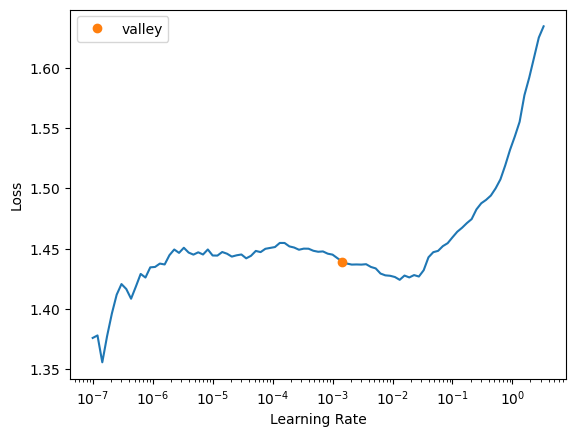

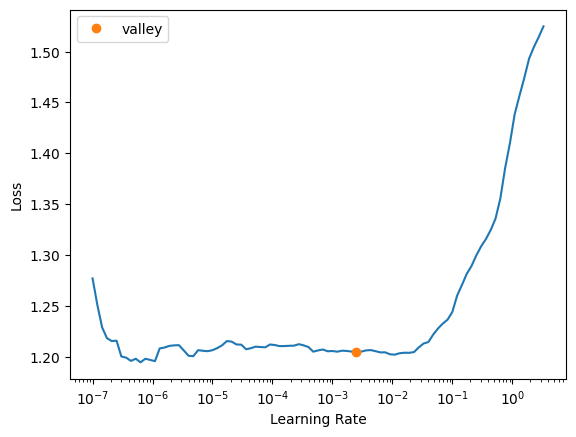

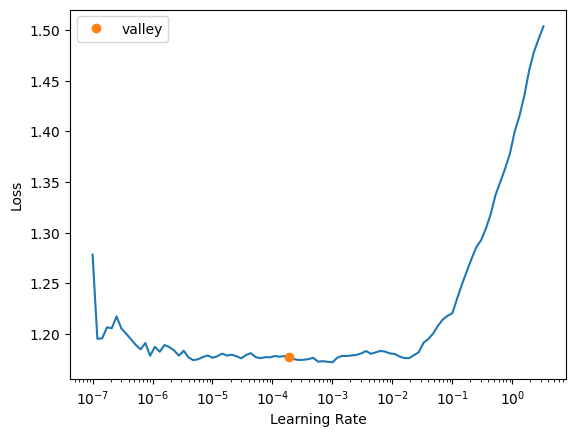

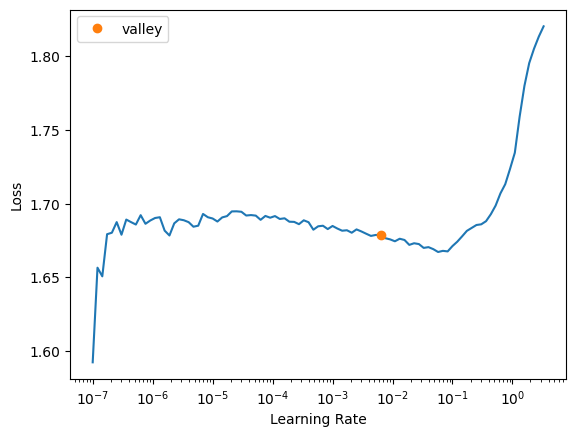

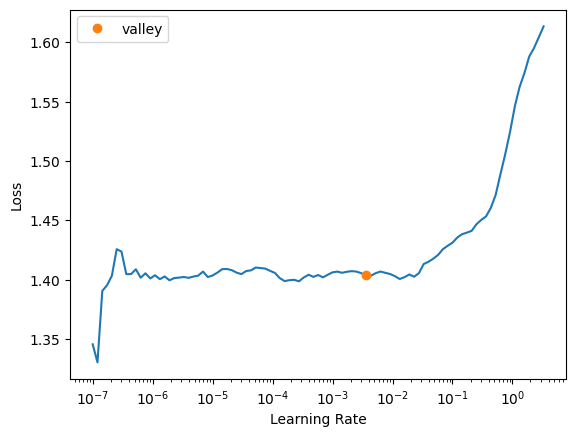

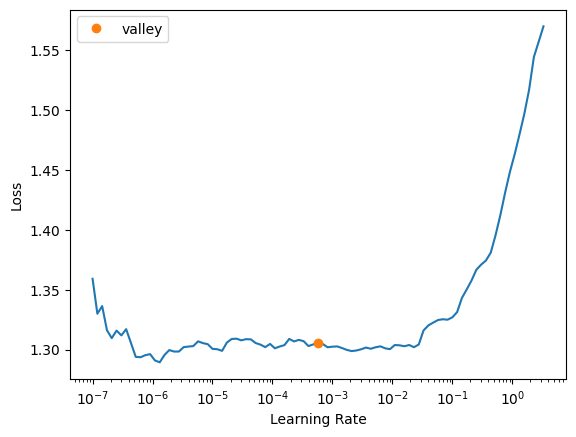

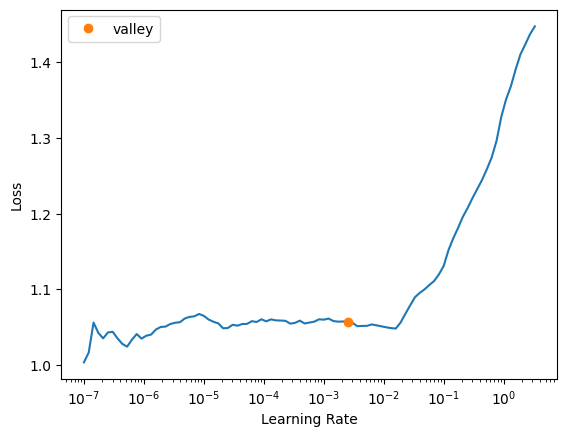

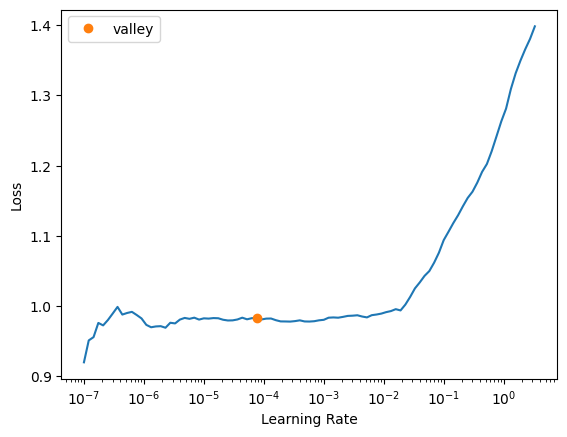

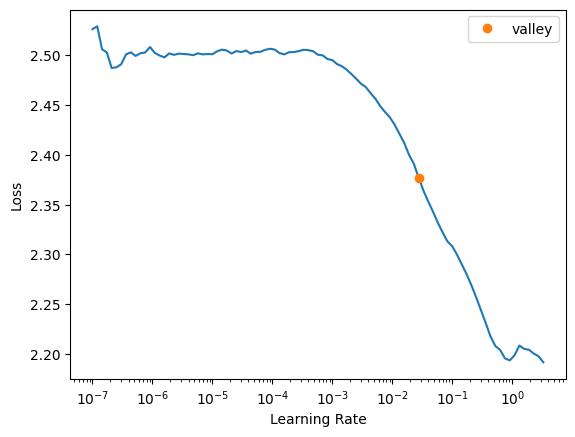

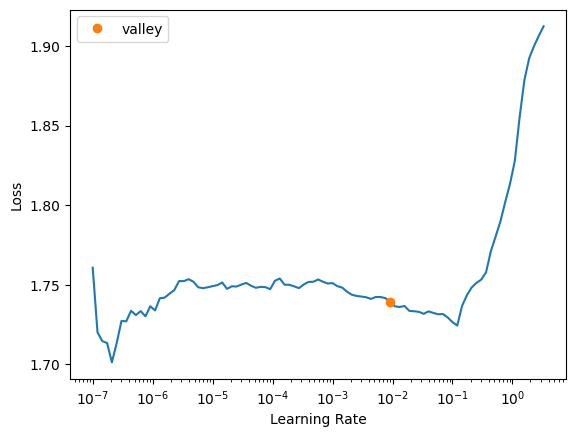

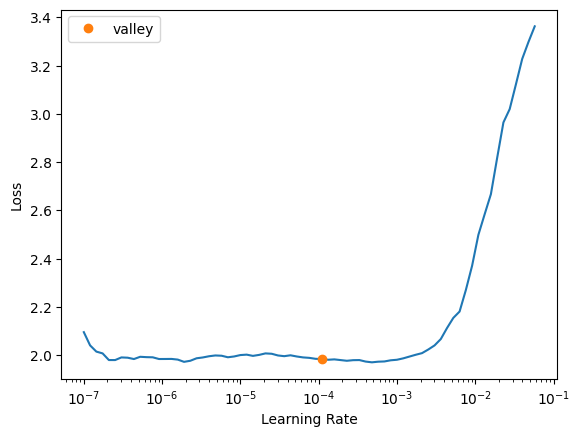

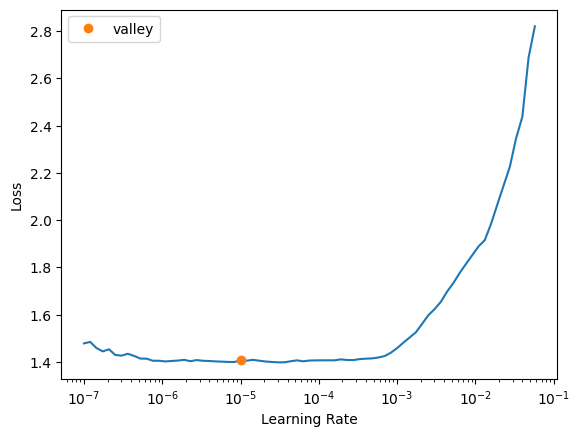

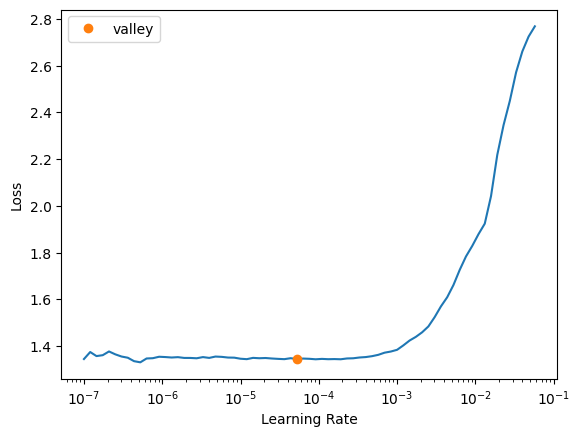

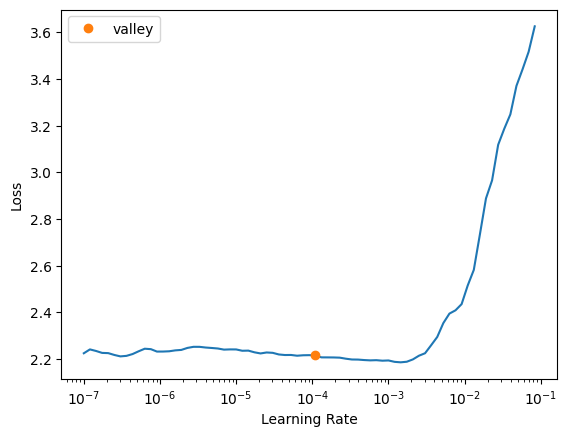

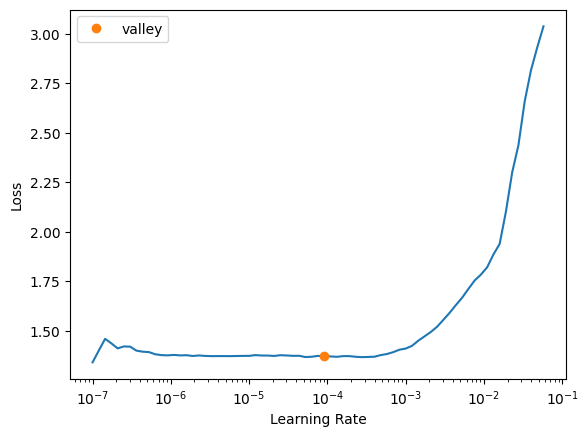

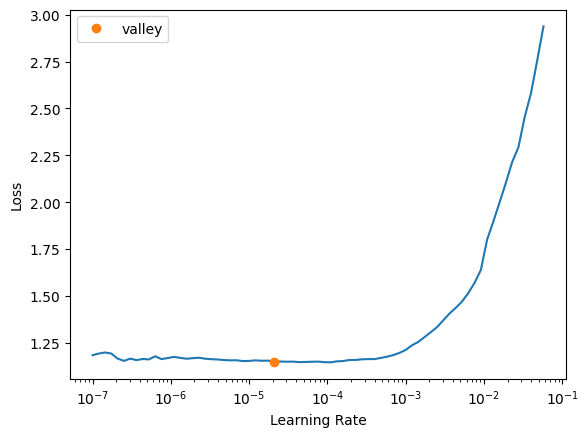

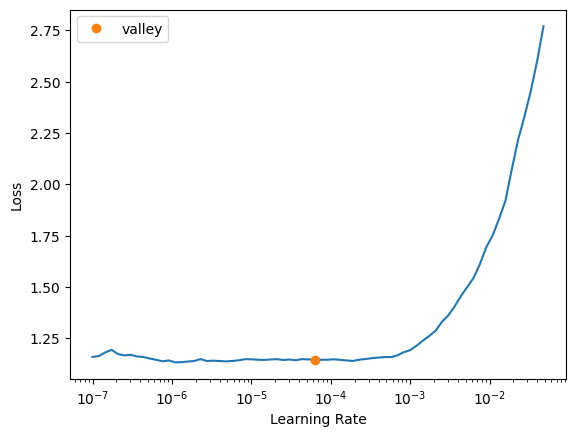

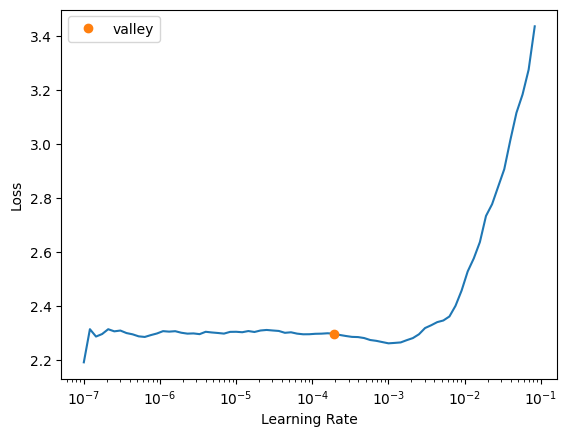

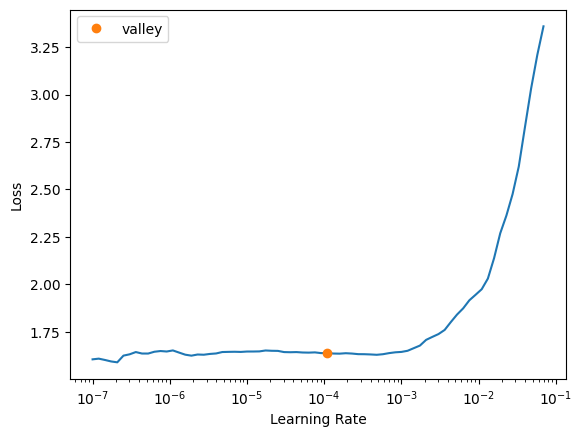

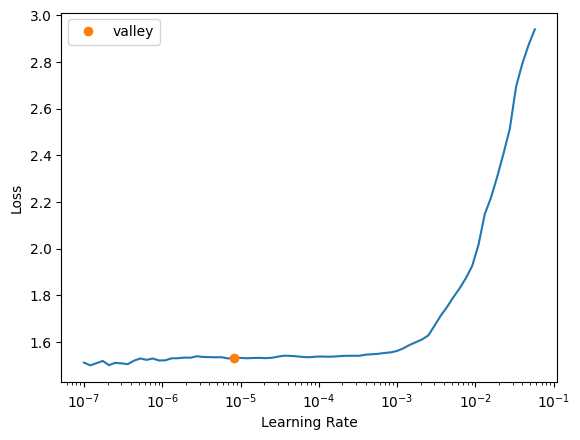

In [11]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for model in ['LeNet5', 'ResNet15']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][model] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]),  max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS-GD'][model], f)


deque([1, 1, 0.22901468099136052], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.2928950786590576.
deque([1, 0.22901468099136052, 0.035797244827362996], maxlen=3)
deque([0.22901468099136052, 0.035797244827362996, 0.017436827493165486], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.1944642066955566.
deque([0.035797244827362996, 0.017436827493165486, 0.021300811611357443], maxlen=3)
Reiniciado
deque([1, 1, 0.4624884486304486], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.2652647495269775.
deque([1, 0.4624884486304486, 0.031307391832693855], maxlen=3)
deque([0.4624884486304486, 0.031307391832693855, 0.019937113226126096], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.2690112590789795.
deque([0.031307391832693855, 0.019937113226126096, 0.026426801874051945], maxlen=3)
Reiniciado
deque([1, 1, 0.44783054260823985], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.3429958820343018.
deque([1, 0.44783054260823985, 0.014494530396052403], maxlen=3)
deque([0.44783054260823985, 0.014494530396052403, 0.016094749021621023], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.3277981281280518.
deque([0.014494530396052403, 0.016094749021621023, 0.006778802869687876], maxlen=3)
Reiniciado
deque([1, 1, 0.4565094044517924], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.3136136531829834.
deque([1, 0.4565094044517924, 0.05826061115692313], maxlen=3)
deque([0.4565094044517924, 0.05826061115692313, 0.0024598580396781255], maxlen=3)


Better model found at epoch 0 with valid_loss value: 2.270512580871582.
deque([0.05826061115692313, 0.0024598580396781255, 0.02570123995874261], maxlen=3)
deque([0.0024598580396781255, 0.02570123995874261, 0.006857096069986328], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 2.3373970985412598.
deque([1, 1, 0.5093144841754248], maxlen=3)
deque([1, 0.5093144841754248, 0.004739417835088271], maxlen=3)


Better model found at epoch 0 with valid_loss value: 4.283724784851074.
deque([0.5093144841754248, 0.004739417835088271, 0.04961725418079589], maxlen=3)


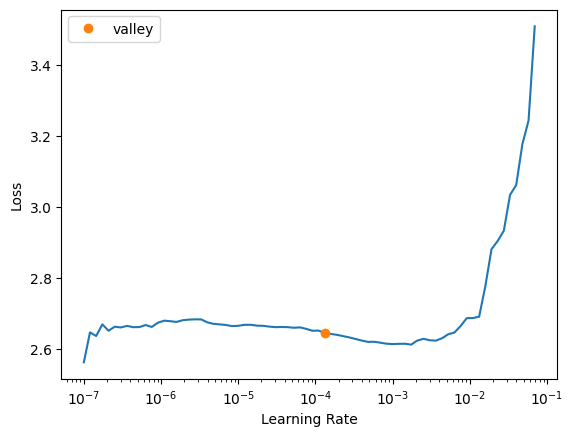

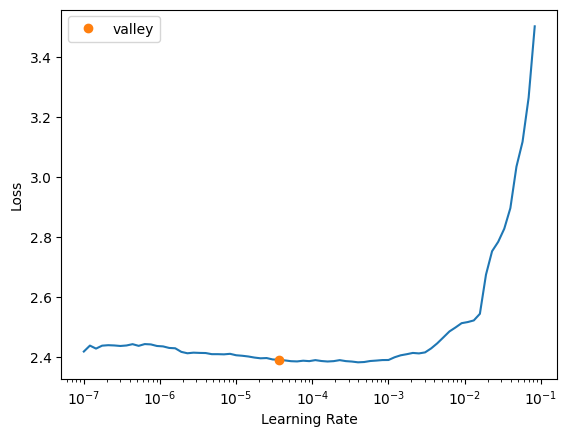

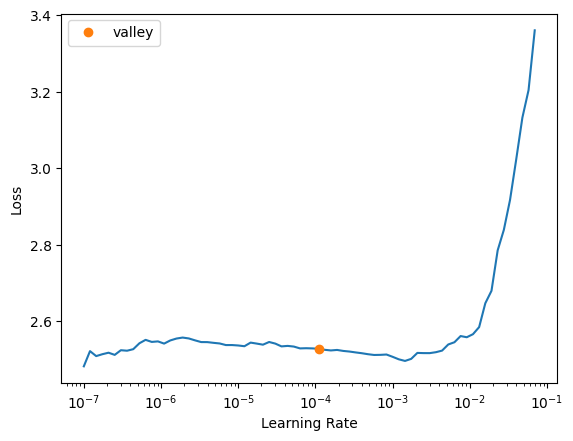

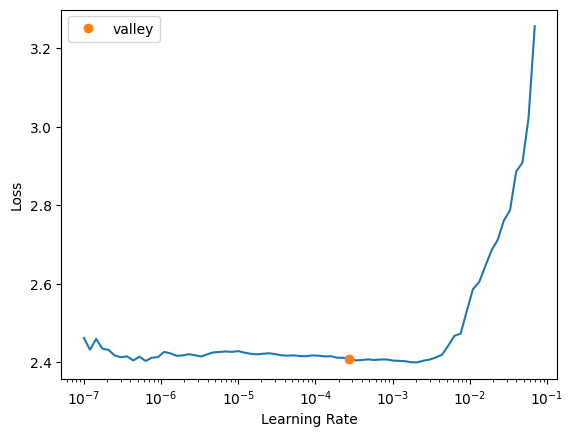

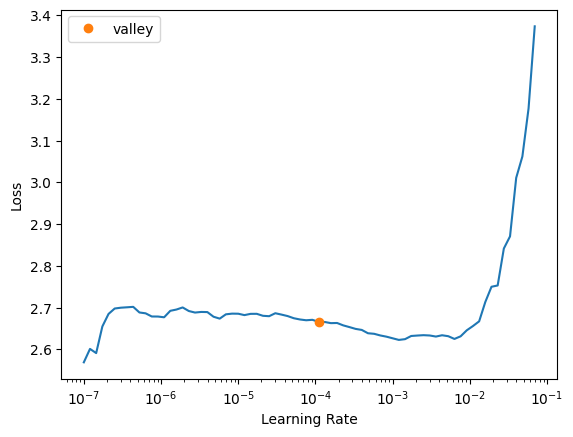

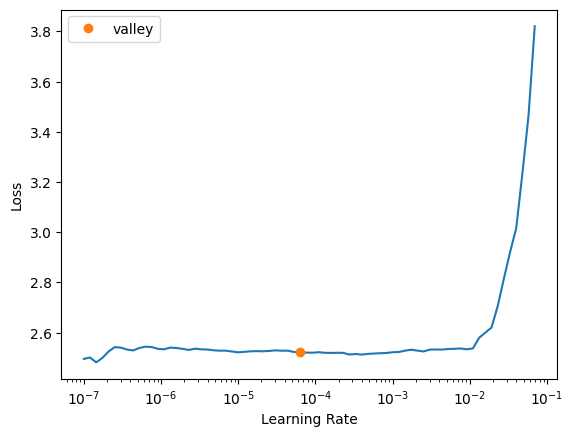

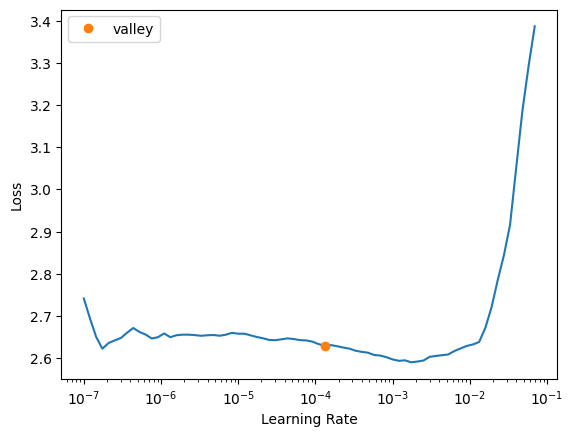

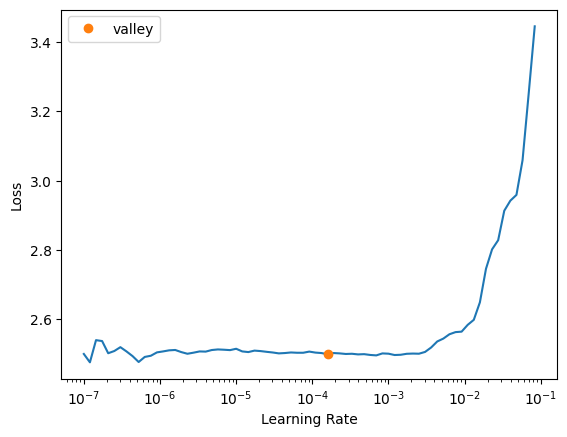

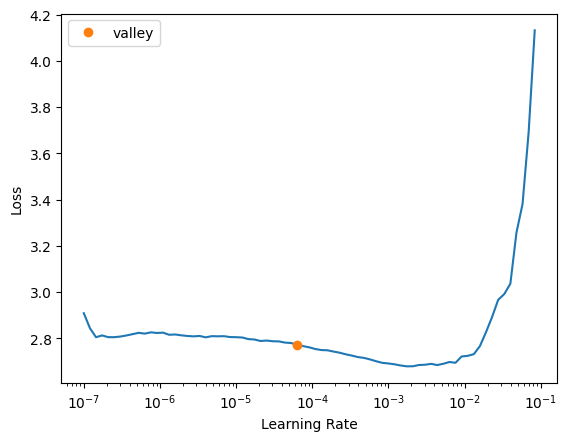

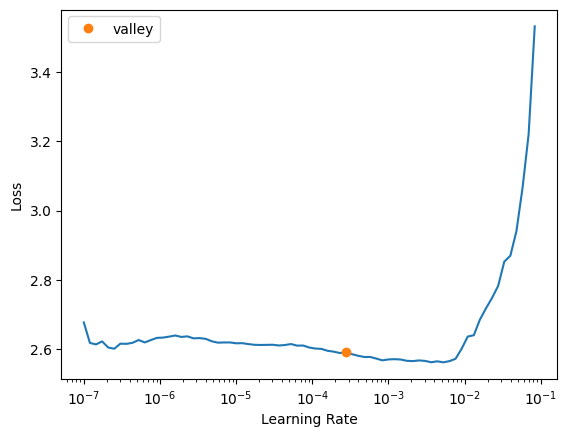

In [12]:
for model in ['ResNet57']:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][model] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[model]), copy.deepcopy(fitness[model]),  max_evals, max_evals_shade, dls, mh_learners[model], mh_learners[model].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][model] = end-start
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'][model], f)
  file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{model}_{dataset}.pkl'
  with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS-GD'][model], f)


In [18]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for model in models:
  fitness_valid['SHADE-ILS-GD'][model] = []
  for ind in results['SHADE-ILS-GD'][model][3]:
    fitness_valid['SHADE-ILS-GD'][model].append(utilsTFG.err_param_valid(ind, mh_learners[model].model, dls))

In [19]:
#Compare train and valid
for model in models:
  print(f"Training error of SHADE-ILS-GD for {model} model: {results['SHADE-ILS-GD'][model][2]}")
  print(f"Validation error of SHADE-ILS-GD for {model} model: {fitness_valid['SHADE-ILS-GD'][model]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][model]) - np.array(results['SHADE-ILS-GD'][model][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][model])
  best['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for LeNet5 model: [2.567852735519409, 1.4238556623458862, 1.289278268814087, 1.2054433822631836, 1.1804503202438354, 1.1734259128570557, 1.1729600429534912, 1.1729600429534912, 1.1729600429534912, 1.1729600429534912, 1.1729600429534912, 1.1729600429534912, 1.1729600429534912, 1.0486239194869995, 0.9894919395446777, 0.9763859510421753, 0.9761093258857727, 0.9749685525894165, 0.9749685525894165, 0.9749685525894165, 0.9749685525894165]
Validation error of SHADE-ILS-GD for LeNet5 model: [2.3009283542633057, 2.5916876792907715, 2.703786849975586, 2.583390474319458, 2.635493278503418, 2.6006360054016113, 2.601987361907959, 2.601987361907959, 2.601987361907959, 2.601987361907959, 2.601987361907959, 2.601987361907959, 2.601987361907959, 2.8579063415527344, 2.6962318420410156, 2.6708502769470215, 2.6924350261688232, 2.6700961589813232, 2.6700961589813232, 2.6700961589813232, 2.6700961589813232]
Difference: [-0.26692438  1.16783202  1.41450858  1.37794709  1.455042

### Save or load

In [ ]:
#Save the mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
#Load the trained mh results
results = {}
for alg in algs:
    results[alg] = {}
    time_mh[alg] = {}
    for model in models:
        file_path = f'/notebooks/saved_models/{alg}_dict_{model}_{dataset}.pkl'
        with open(file_path, 'rb') as f:
            results[alg][model] = pickle.load(f)
        file_path = f'/notebooks/saved_models/{alg}_time_{model}_{dataset}.pkl'
        with open(file_path, 'rb') as f:
            time_mh[alg][model] = pickle.load(f)


### Comparison between MH

In [20]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for model in models:
  training['SHADE'][model] = results['SHADE'][model][6]
  training['SHADE-ILS'][model] = results['SHADE-ILS'][model][2]
  training['SHADE-GD'][model] = results['SHADE-GD'][model][2]
  training['SHADE-ILS-GD'][model] = results['SHADE-ILS-GD'][model][2]

In [21]:
from fastai.metrics import accuracy
#Calculate accuracy
#Calculate accuracy
acc = {}
for mh in algs:
  acc[mh] = {}
  for model in models:
    acc[mh][model] = []
    ind = 5 if mh == 'SHADE' else 3
    start = time.perf_counter()
    for ind in results[mh][model][ind]:
      utilsTFG.set_params_to_model(ind, mh_learners[model].model)
      mh_learners[model].model.eval()
      mh_learners[model].eval()
      preds, targs = mh_learners[model].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      acc[mh][model].append(accuracy(preds, targs))
    end = time.perf_counter()
    #time_full_mh[mh][model]+= end-start

<Figure size 1200x600 with 0 Axes>

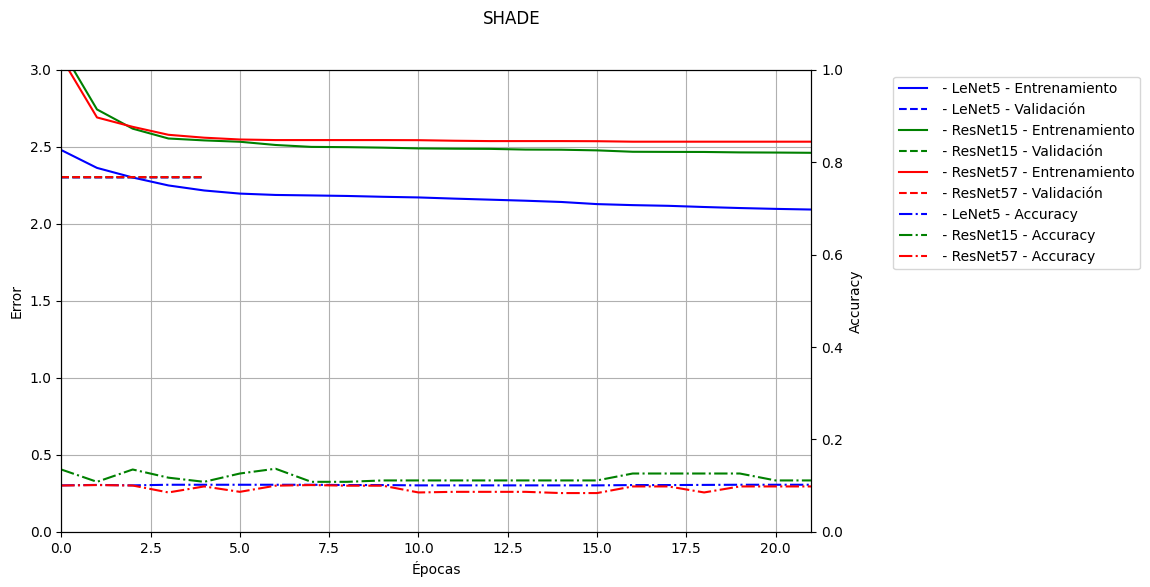

<Figure size 1200x600 with 0 Axes>

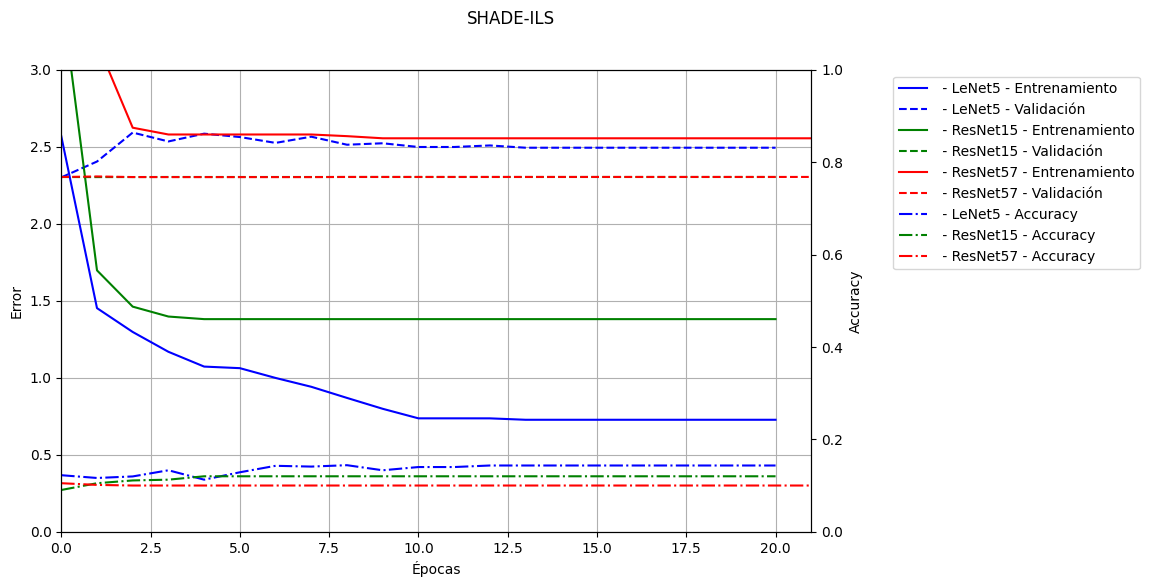

<Figure size 1200x600 with 0 Axes>

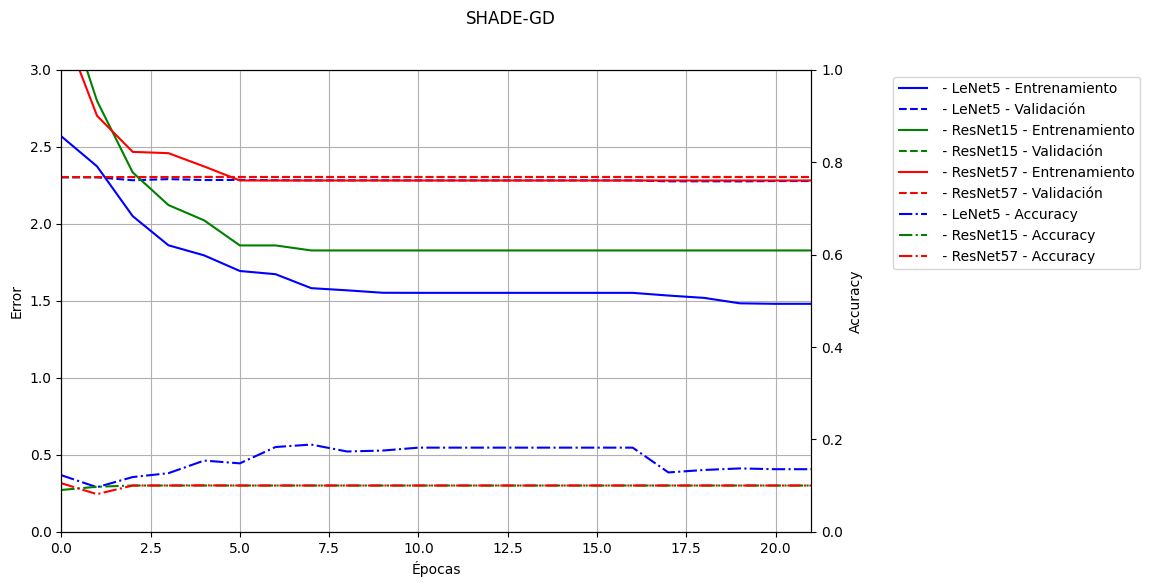

<Figure size 1200x600 with 0 Axes>

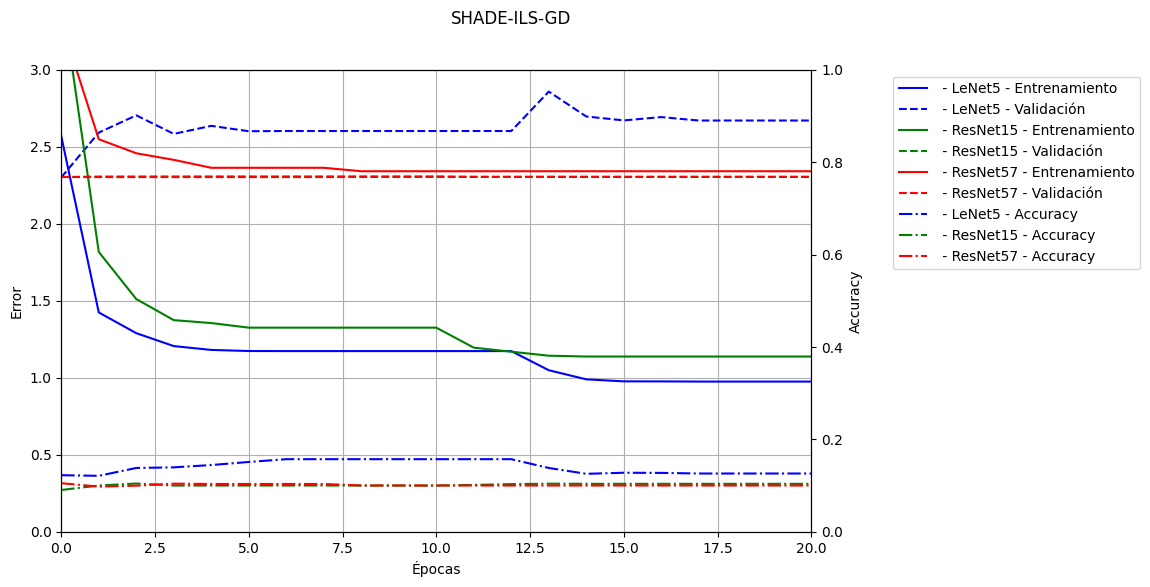

In [22]:
#Comparing the different layers version of the same MH
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], acc[alg], lim = 3, layers=models, names=models, title=f'{alg}', metric='accuracy')

<Figure size 1200x600 with 0 Axes>

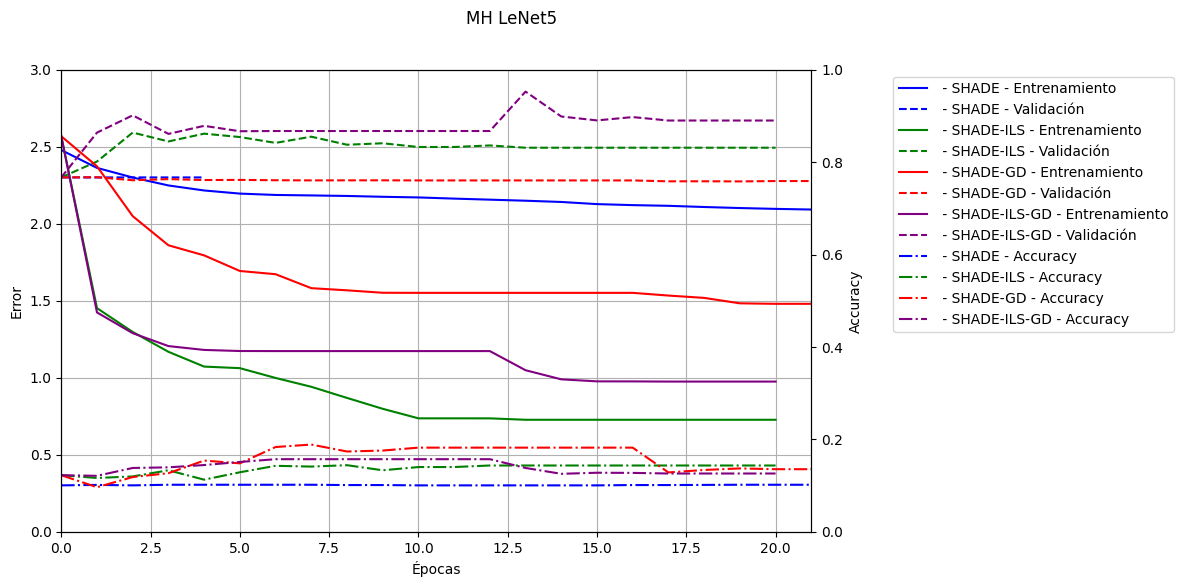

<Figure size 1200x600 with 0 Axes>

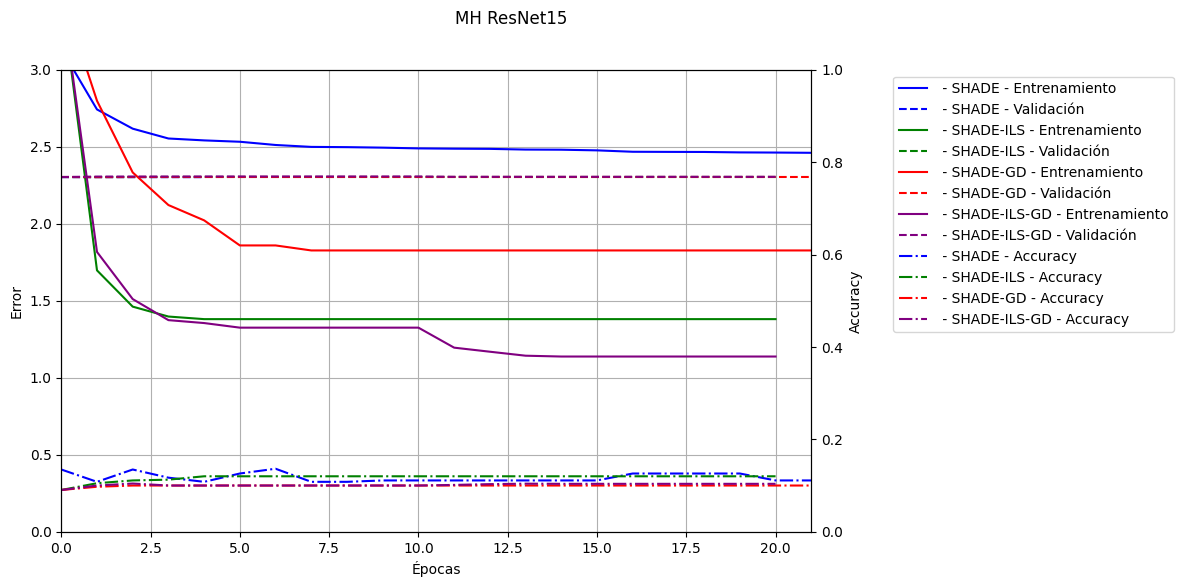

<Figure size 1200x600 with 0 Axes>

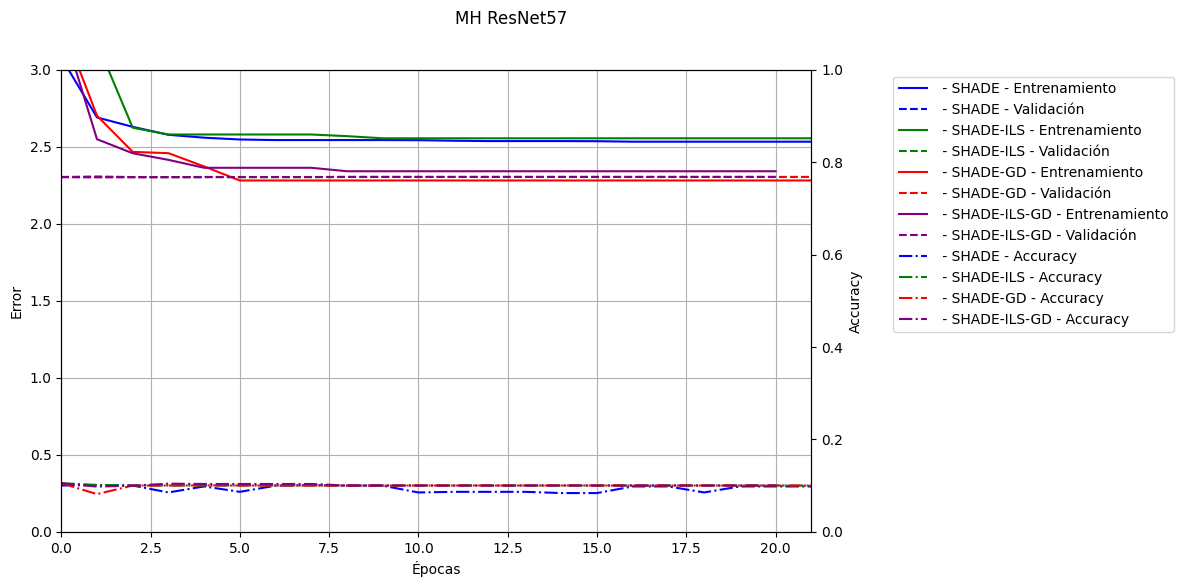

In [23]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
ac = {}
valid = {}
for model in models:
  train[model] = {}
  ac[model] = {}
  valid[model] = {}
  for alg in algs:
    train[model][alg] = training[alg][model]
    ac[model][alg] = acc[alg][model]
    valid[model][alg] = fitness_valid[alg][model]
  utilsTFG.plot_mh_mlp_training(train[model], valid[model], ac[model],  layers=names, lim = 3, names=names, title=f'MH {model}', metric='accuracy')

### Generalization

In [32]:
#Run the model in the test set
for mh in algs:
  for model in models:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][model], mh_learners[model].model)
    mh_learners[model].model.eval()
    mh_learners[model].eval()
    preds, targs = mh_learners[model].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate accuracy

    accur = utilsTFG.balanced_accuracy_func(preds, targs)


    loss = utilsTFG.err_param_w_model(mh_learners[model].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Model: {model}, Loss: {loss}, Accuracy: {accur}")

Optimizer: SHADE, Model: LeNet5, Loss: 2.3004345893859863, Accuracy: 0.1016


Optimizer: SHADE, Model: ResNet15, Loss: 2.302544593811035, Accuracy: 0.1106


Optimizer: SHADE, Model: ResNet57, Loss: 2.3025565147399902, Accuracy: 0.0992


Optimizer: SHADE-ILS, Model: LeNet5, Loss: 2.30100679397583, Accuracy: 0.11440000000000002


Optimizer: SHADE-ILS, Model: ResNet15, Loss: 2.3028554916381836, Accuracy: 0.1032


Optimizer: SHADE-ILS, Model: ResNet57, Loss: 2.3028206825256348, Accuracy: 0.1


Optimizer: SHADE-GD, Model: LeNet5, Loss: 2.275235414505005, Accuracy: 0.14200000000000002


Optimizer: SHADE-GD, Model: ResNet15, Loss: 2.3026857376098633, Accuracy: 0.09559999999999999


Optimizer: SHADE-GD, Model: ResNet57, Loss: 2.3025267124176025, Accuracy: 0.0932


Optimizer: SHADE-ILS-GD, Model: LeNet5, Loss: 2.30100679397583, Accuracy: 0.11440000000000002


Optimizer: SHADE-ILS-GD, Model: ResNet15, Loss: 2.3033108711242676, Accuracy: 0.09319999999999999


Optimizer: SHADE-ILS-GD, Model: ResNet57, Loss: 2.3027875423431396, Accuracy: 0.096


## Time comparison

In [33]:
#Compare times for each algorithm and layer

#GD
for alg, time_model in time_mh.items():
  for model, time in time_model.items():
    print(f'Time consumed by {alg} training with {model}: {time:.04f} seconds')

#MH
for optims, time_model in time_gd.items():
  for model, time in time_model.items():
    print(f'Time consumed by {optims} training with {model}: {time:.04f} seconds')



Time consumed by SHADE training with LeNet5: 6646.4676 seconds
Time consumed by SHADE training with ResNet15: 7690.7276 seconds
Time consumed by SHADE training with ResNet57: 10812.2772 seconds
Time consumed by SHADE-ILS training with LeNet5: 7391.9709 seconds
Time consumed by SHADE-ILS training with ResNet15: 8104.5046 seconds
Time consumed by SHADE-ILS training with ResNet57: 8744.1071 seconds
Time consumed by SHADE-GD training with LeNet5: 7586.1584 seconds
Time consumed by SHADE-GD training with ResNet15: 8444.6298 seconds
Time consumed by SHADE-GD training with ResNet57: 7856.4339 seconds
Time consumed by SHADE-ILS-GD training with LeNet5: 6279.1957 seconds
Time consumed by SHADE-ILS-GD training with ResNet15: 7034.9582 seconds
Time consumed by SHADE-ILS-GD training with ResNet57: 9035.0288 seconds
Time consumed by NAG training with LeNet5: 115.5313 seconds
Time consumed by NAG training with ResNet15: 126.6598 seconds
Time consumed by NAG training with ResNet57: 141.4139 seconds
T

In [16]:
for alg, time_layers in time_full_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.03f} seconds')

Time consumed by SHADE training with LeNet5 layers: 6831.071 seconds
Time consumed by SHADE training with ResNet15 layers: 7874.578 seconds
Time consumed by SHADE training with ResNet57 layers: 11003.481 seconds
Time consumed by SHADE-ILS training with LeNet5 layers: 7453.761 seconds
Time consumed by SHADE-ILS training with ResNet15 layers: 8164.679 seconds
Time consumed by SHADE-ILS training with ResNet57 layers: 8812.613 seconds
